In [142]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import altair as alt

import scipy.cluster.hierarchy as hc

import rdatasets  as rds
from sklearn.datasets import load_iris, load_wine, fetch_olivetti_faces, load_digits, make_blobs, make_moons

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import rand_score, adjusted_rand_score, silhouette_score, silhouette_samples, adjusted_mutual_info_score, normalized_mutual_info_score, confusion_matrix, ConfusionMatrixDisplay, pair_confusion_matrix

# Clustering Algorithms: K-Means, Hierarchical, and DBSCAN

Clustering is an unsupervised learning technique that groups data points into clusters such that points in the same cluster are more similar to each other than to those in different clusters. In this lecture I am going to provide a comprehensive overview of three popular clustering algorithms: 

1. **K-Means**
2. **Hierarchical Clustering**, and
3. **DBSCAN**

I am going to cover their theoretical foundations, mathematical derivations, real-world applications, comparisons of their strengths/weaknesses, and example Python implementations. The aim is to deepen understanding of how these algorithms work and when to use each.

## Theoretical Background

Clustering algorithms can be broadly categorized by their approach to forming clusters. **K-Means** is a **partitioning** method that explicitly partitions the dataset into *k* clusters by iteratively refining cluster centers. **Hierarchical clustering** builds a tree of clusters (a dendrogram) either by successive merges (agglomerative) or splits (divisive), without needing to pre-specify the number of clusters. **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) is a **density-based** method that groups points by areas of high density and identifies outliers in sparse regions ([DBSCAN - Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density,2)).

### K-Means Clustering (Partitioning Method)

K-Means is one of the most widely used clustering algorithms. It assumes clusters are roughly spherical in the feature space and tries to find cluster centers (centroids) that minimize the distances of points to their nearest center. References: "[Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=Different%20clustering%20algorithms%20show%20varied,of%20the%20clusters%20they%20form)" and "[A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)."

The algorithm is typically implemented via **Lloyd’s iterative method**, which alternates between two steps:

1. **Assignment Step**: Assign each data point to the nearest cluster centroid (often using Euclidean distance).
2. **Update Step**: Recompute each centroid as the mean of all points assigned to that cluster.

These two steps repeat until convergence (no change in assignments or centroids). This procedure is guaranteed to decrease the clustering objective at each iteration and will converge to a local minimum of the cost function (though not necessarily the global minimum, as the optimization problem is NP-hard in general ([Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=Finding%20the%20optimal%20solution%20to,observations%20in%20d%20dimensions%20is))). The result is a partition of the data into *k* clusters with their respective centroids.

**Intuition**: The centroid (mean) represents the “center of mass” of points in a cluster, so re-centering at the mean minimizes the within-cluster variance. Each iteration refines the clusters: the assignment step creates clusters based on current centroids, and the update step shifts centroids to better fit those clusters. K-Means tends to produce convex (approximately spherical) clusters and may struggle with complex shapes or clusters of very different sizes.

### Hierarchical Clustering (Agglomerative Method)

Hierarchical clustering creates a hierarchy of cluster groupings, often visualized as a **dendrogram**. The most common approach is **agglomerative hierarchical clustering**, which is a bottom-up method:

- Start with each data point as its own cluster.
- Iteratively merge the two “closest” clusters until only one cluster remains (or a stopping criterion is met).

The definition of “closest” cluster is determined by a **linkage criterion**, which is a rule for computing distance between clusters from the distances between their points 
([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=Hierarchical%20clustering%27s%20primary%20concern%20is,clusters%20are%20merged%20or%20split)). Common linkage criteria include:

- **Single Linkage** (minimum distance): distance between two clusters = smallest distance between any single point in one cluster and any point in the other. This can result in elongated or “chained” clusters ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=nature%20allows%20it%20to%20adapt,might%20be%20intertwined%20or%20elongated)).
- **Complete Linkage** (maximum distance): distance = largest distance between any point in one cluster and any point in the other, tending to produce more compact, spherical clusters ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=For%20hierarchical%20clustering%2C%20the%20shape,create%20more%20compact%2C%20rounder%20clusters)).
- **Average Linkage** (mean distance): distance = average pairwise distance between points in the two clusters.
- **Ward’s Method** (minimum variance): merges clusters that result in the smallest increase in overall within-cluster variance (i.e., minimizes the sum of squared deviations from cluster centroids at each merge).

Hierarchical clustering does **not require specifying the number of clusters *a priori***. Instead, one can “cut” the dendrogram at a chosen level to obtain a desired number of clusters or select clusters based on a distance threshold. This flexibility is useful for exploring data at multiple granularity levels ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=In%20hierarchical%20clustering%2C%20the%20dendrogram,in%20determining%20the%20cluster%20count)). Hierarchical methods can use **any distance metric** (Euclidean, Manhattan, etc.), making them versatile in handling different data types (even a custom distance matrix) ([Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering#:~:text=Hierarchical%20clustering%20has%20the%20distinct,citation%20needed)). However, they are greedy: once a merge is done, it cannot be undone, which may lead to suboptimal clusters if a poor merge happens early. Agglomerative clustering is deterministic for a given distance metric and linkage criterion, yielding the same clustering each run.

### DBSCAN (Density-Based Method)

DBSCAN is a density-based clustering approach that discovers clusters of arbitrary shape ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)) and identifies points that lie alone in sparse areas as **noise** ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density,2)). It was introduced by Ester, Kriegel, Sander, and Xu in 1996 ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density,2)). DBSCAN requires two parameters: **ε (epsilon)** – the radius of the neighborhood to consider around a point, and **MinPts** – the minimum number of points required in an ε-neighborhood for a point to be considered a core point.

The algorithm works as follows:

- **Core Points**: If a point has at least MinPts points (including itself) within distance ε, it is labeled a *core point* ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=purpose%20of%20DBSCAN%20clustering%2C%20the,points%20and%20outliers%2C%20as%20follows)). These points lie in dense regions.
- **Direct Reachability**: A point *q* is directly reachable from a core point *p* if *q* is within ε of *p*. In other words, *q* is in the neighborhood of *p*. Only core points can directly reach other points; by definition, non-core points cannot act as sources of reachability ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=match%20at%20L394%20Reachability%20is,Therefore%2C%20a%20further%20notion%20of)).
- **Reachability**: A point *q* is reachable from *p* if there exists a chain of points $p \to p_1 \to p_2 \to \cdots \to p_n \to q$ where each point is directly reachable from the previous one. This implies *p* must be a core point and all intermediate points in the chain are core points as well ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=core%20point%20p,the%20path%20must%20be%20core)).
- **Cluster Formation**: Any core point forms a cluster with all points (core or non-core) that are reachable from it. Non-core points in a cluster are often called *border points* – they are not dense in themselves but lie in the neighborhood of a core point. Points that are not reachable from any core point are labeled as *outliers* or *noise* ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Now%20if%20p%20is%20a,used%20to%20reach%20more%20points)).

In essence, DBSCAN finds clusters by growing regions from core points: it picks an arbitrary point, finds its ε-neighborhood, and if that neighborhood has MinPts or more points (core), a new cluster is started and expanded by recursively adding all points reachable from these core points. The process repeats until all points are either assigned to a cluster or marked as noise.

**Intuition**: Clusters are seen as areas of the dataset with a higher density of points than the remainder of the dataset. DBSCAN is well-suited for datasets where clusters are irregularly shaped (not necessarily convex) and where we want to detect and exclude outliers rather than force every point into a cluster ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)) ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Handling%20Outliers)). It does not require specifying the number of clusters in advance; the number of clusters emerges from the data given the density parameters ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=DBSCAN%20inherently%20determines%20the%20number,the%20clustering%20structure%20is%20unknown)). However, choosing appropriate ε and MinPts is important – too large an ε or too low a MinPts can merge distinct clusters, while too strict parameters can leave the data fragmented or label too many points as noise.

## Mathematical Derivations

This section delves into the mathematical foundations of the algorithms, including objective functions and derivations for how clusters are formed or evaluated.

### K-Means: Objective Function and Optimization

**Objective Function:** K-Means clustering aims to find cluster assignments and centroids that minimize the *within-cluster sum of squared distances*. Formally, given a set of data points $X = \{\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n\}$ in $\mathbb{R}^d$ and a chosen number of clusters $k$, the goal is to find sets $C_1, C_2, \dots, C_k$ (a partition of $\{1,\dots,n\}$) and centroids $\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_k$ that minimize:

$$
J = \sum_{j=1}^{k} \sum_{i \in C_j} \|\mathbf{x}_i - \boldsymbol{\mu}_j\|^2,
$$

where $\|\mathbf{x}_i - \boldsymbol{\mu}_j\|^2$ is the (squared) distance between point $\mathbf{x}_i$ and the centroid of cluster $j$. This cost function $J$ is often called the **within-cluster sum of squares (WCSS)** or distortion. It measures cluster compactness; lower values indicate tighter clusters around their centroids.

**Optimization by Alternating Minimization:** Solving this minimization exactly is NP-hard in general ([Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=Finding%20the%20optimal%20solution%20to,observations%20in%20d%20dimensions%20is)), but the K-Means algorithm finds a local minimum by alternating between two partial optimizations:

- **Given centroids $\{\boldsymbol{\mu}_j\}$, assign each point to the nearest centroid:**  
  For each $i$, find cluster index $j$ that minimizes $\|\mathbf{x}_i - \boldsymbol{\mu}_j\|$. This is assigning $i$ to its closest center. This step optimally assigns points to clusters for the current centroids (it’s minimizing $J$ with centroids fixed).

- **Given assignments $C_1,\dots,C_k$, recompute each centroid as the mean of its cluster:**  
  For each cluster $j$, update $\boldsymbol{\mu}_j = \frac{1}{|C_j|}\sum_{i \in C_j} \mathbf{x}_i$. This choice minimizes $J$ for fixed assignments because the mean is the point that minimizes the sum of squared distances to points in the cluster (derivation: set $\partial J/\partial \boldsymbol{\mu}_j = 0$ yields $\boldsymbol{\mu}_j = \frac{1}{|C_j|}\sum_{i \in C_j} \mathbf{x}_i$).

These updates monotonically decrease (or at least do not increase) the objective $J$ ([Link](http://www.cs.yale.edu/homes/el327/datamining2013aFiles/10_k_means_clustering.pdf#:~:text=end%20while%20This%20algorithm%20can,X%20i%E2%88%88Sj%20kxi%20%E2%88%92%20%C2%B5jk)) ([Link](http://www.cs.yale.edu/homes/el327/datamining2013aFiles/10_k_means_clustering.pdf#:~:text=fixed%2C%20the%20best%20assignment%20is,S)). Specifically, the assignment step guarantees the closest-centroid assignment is optimal for that iteration, and the update step guarantees the new centroid is optimal for the assigned points. Thus, $J$ decreases until convergence. In practice, K-Means typically converges in a reasonable number of iterations. The final solution is a (local) minimum of $J$. 

**Distance Metric:** Standard K-Means uses Euclidean distance, which leads to the mean as the optimal centroid update. If a different distance (e.g., Manhattan) is used, the update would use the corresponding median instead of mean.

**Result of Optimization:** The output is a set of centroids $\{\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_k\}$ and cluster labels for each point (indicating which $C_j$ it belongs to). The clustering partitions the space into Voronoi regions around each centroid. The sum of squared distances $J$ can be used to evaluate cluster compactness. (One may also compute the **between-cluster sum of squares** to evaluate separation, or use **silhouette scores** for assessing clustering quality, though those are beyond the K-Means algorithm itself.)

### Hierarchical Clustering: Linkage Distance Calculations

Hierarchical agglomerative clustering requires computing distances between clusters at each merge. If we have a distance (dissimilarity) function $d(p,q)$ defined between individual points $p$ and $q$, we need to extend it to define distance between a set of points $A$ (cluster) and another set $B$ (cluster). The **linkage criteria** are mathematical definitions of this inter-cluster distance. Table 1 summarizes common linkage formulas, where $A$ and $B$ are two clusters, and $|A|$ denotes the number of points in cluster $A$:

| **Linkage Criterion**        | **Distance Between Cluster $A$ and $B$**                                       | **Characteristics**                   |
|-----------------------------|-------------------------------------------------------------------------------|---------------------------------------|
| **Single Linkage**          | $d_{\min}(A,B) \;=\; \min_{a \in A,\;b \in B} \; d(a,b)$                       | Nearest points determine cluster distance. Can form *chain-like* clusters (good for arbitrary shapes, but sensitive to noise). |
| **Complete Linkage**        | $d_{\max}(A,B) \;=\; \max_{a \in A,\;b \in B} \; d(a,b)$                       | Farthest points determine distance. Tends to produce *compact, spherical* clusters (limits chaining). |
| **Average Linkage**         | $d_{\text{avg}}(A,B) \;=\; \frac{1}{|A|\,|B|}\sum_{a\in A}\sum_{b\in B} d(a,b)$ | Uses average pairwise distance between points of clusters. Balanced, not as sensitive to outliers as single/complete. |
| **Ward’s Method (Min Var)** | $d_{\text{Ward}}(A,B) \;=\; \frac{|A|\,|B|}{|A| + |B|} \;\| \boldsymbol{\mu}_A - \boldsymbol{\mu}_B \|^2$           | Distance = increase in SSE when merging $A$ and $B$. Merges minimize variance within clusters, akin to K-Means objective at each step. |

*Table 1: Common linkage criteria in agglomerative hierarchical clustering, with their formulas and characteristics.* ([Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering#:~:text=Maximum%20or%20complete,a%5Cin%20A%2C%5C%2Cb%5Cin%20B%7Dd%28a%2Cb)) ([Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering#:~:text=Ward%20linkage%2C,sum))

At the start of agglomerative clustering, each data point is its own cluster. The algorithm then repeatedly merges the pair of clusters with the smallest inter-cluster distance (according to the chosen linkage) until one cluster remains or a stopping condition. The result can be represented as a binary tree of merges (dendrogram). To obtain $m$ clusters, one can cut the dendrogram at a height that leaves $m$ clusters. Notably, single linkage clustering has a theoretical connection to the minimum spanning tree: if one cuts a single-linkage dendrogram at distance $\epsilon$, the clusters correspond to connected components in a graph where edges connect points within $\epsilon$ distance – this equivalence means single linkage effectively finds any-shaped clusters similar to a thresholded MST (but it is also prone to “chaining” effects where clusters can become straggly). Complete linkage, by contrast, ensures all points in a cluster are relatively close, avoiding chaining at the cost of possibly breaking true clusters that have slight chaining connections. Ward’s method is effectively a greedy top-down approximation to K-Means: it tries to minimize the total within-cluster variance at each merge.

### DBSCAN: Density Reachability and Core Point Conditions

DBSCAN’s mathematical foundation is based on the notion of ε-neighborhoods and density reachability:

- **ε-Neighborhood**: For a point $p$, the $\epsilon$-neighborhood is $N_{\epsilon}(p) = \{ q \mid d(p,q) \le \epsilon \}$ (using a chosen distance metric, often Euclidean). This is the set of points within distance ε of $p$ (including $p$ itself).

- **Core Point Criterion**: $p$ is a *core point* if $|N_{\epsilon}(p)| \ge \text{MinPts}$. In other words, there are at least MinPts points (typically counting $p$ itself in that total) within distance ε of $p$ ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=purpose%20of%20DBSCAN%20clustering%2C%20the,points%20and%20outliers%2C%20as%20follows)). MinPts is usually chosen >= 3 (if MinPts = 1 or 2, every point tends to become core or it reduces to something like single-linkage clustering ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=match%20at%20L610%20does%20not,are%20usually%20better%20for%20data))).

- **Direct Density Reachable**: A point $q$ is directly density-reachable from $p$ if $p$ is a core point and $q \in N_{\epsilon}(p)$ (i.e., $d(p,q)\le \epsilon$). Note this relation is not symmetric; $q$ could be reachable from $p$ even if $q$ is not a core point (reachable *to* $q$) ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=match%20at%20L394%20Reachability%20is,of%20the%20clusters%20found%20by)).

- **Density Reachable (Transitive Closure)**: $q$ is density-reachable from $p$ if there exists a sequence of points $p = p_0, p_1, ..., p_m = q$ such that $p_{i+1}$ is directly density-reachable from $p_i$ for all $0 \le i < m$. This implies $p_0$ must be a core point, and each link in the chain $p_i \to p_{i+1}$ goes from a core point to one of its neighbors. In effect, $q$ lies within a chain of neighboring dense regions starting from $p$.

- **Density-Connected**: Two points $p$ and $q$ are density-connected if there exists a third point $o$ such that *both* $p$ and $q$ are density-reachable from $o$. This defines a connectivity relation among points via dense regions.

Using these definitions, DBSCAN defines a *cluster* as a set of points that are all density-connected to each other (there will always be at least one core point in a cluster to serve as a nucleus). Any point not belonging to any cluster is labeled as noise. Formally, one can show that for a given ε and MinPts, DBSCAN produces clusters that satisfy a maximality property: if a point is density-reachable from any point of a cluster, it is part of that cluster. And each cluster contains at least one core point, and all core points in a cluster are mutually density-connected ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Now%20if%20p%20is%20a,used%20to%20reach%20more%20points)).

**Density Estimation vs Parameter Choice**: DBSCAN does not explicitly estimate a *numeric density* like a probability density function; instead, ε and MinPts define a cutoff for density (a *region is dense* if it contains MinPts points in an ε radius). In practice, choosing ε is often aided by a *k-distance graph* (plotting the distance to the k-th nearest neighbor for each point, sorted by those distances, and looking for an “elbow” that suggests a natural distance threshold for clustering). MinPts is often set to a small integer (e.g., 4 or 5 for 2D data, higher for higher dimensions) based on domain knowledge or guidelines (a common rule of thumb is MinPts = 2 * dim, but at least 3) ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=We%20use%20scikit)).

The time complexity of a naive DBSCAN implementation is $O(n^2)$ (checking each point’s ε-neighborhood by scanning all points). However, with spatial index structures (like k-d trees or ball trees for low-dimensional data), the average complexity can approach $O(n \log n)$ ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=DBSCAN%2C%20while%20linear%20in%20nature%2C,search%2C%20making%20DBSCAN%20more%20scalable)). DBSCAN can be less efficient in very high dimensions (where indexing is hard and distances become less meaningful due to the curse of dimensionality) or if the data is such that almost all points end up in one cluster (worst-case $O(n^2)$ if every point is a neighbor to many others). 

## Comparisons of K-Means, Hierarchical, and DBSCAN

Each of these algorithms has its own strengths and weaknesses. The best choice depends on the dataset characteristics and the goals of analysis. Table 2 provides a high-level comparison:

| **Aspect**              | **K-Means**                                              | **Hierarchical**                                            | **DBSCAN**                                                            |
|-------------------------|----------------------------------------------------------|-------------------------------------------------------------|-----------------------------------------------------------------------|
| **Cluster Shape Bias**  | Prefers convex (spherical) clusters ([A Guide to the DBSCAN Clustering Algorithm at DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)).       | Depends on linkage: single linkage can find elongated clusters; complete/average/ward favor compact clusters. | Can find clusters of arbitrary shape ([A Guide to the DBSCAN Clustering Algorithm at DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)) (density-connected arbitrary regions). |
| **# of Clusters**       | Must specify $k$ in advance.                             | No need to pre-specify; produces a full dendrogram. Choose clusters by cutting tree ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods at Hex ](https://hex.tech/blog/comparing-density-based-methods/#:~:text=In%20hierarchical%20clustering%2C%20the%20dendrogram,in%20determining%20the%20cluster%20count)). | No need to specify *k*; number of clusters determined by ε & MinPts (algorithm finds however many dense clusters exist). |
| **Handling Outliers**   | No explicit notion of outliers – all points get assigned to some cluster. Outliers can skew centroids. | No explicit outlier handling – eventually every point will merge into the hierarchy (though one can manually cut the dendrogram to isolate small clusters as outliers). | Explicitly identifies noise points that do not belong to any cluster ([A Guide to the DBSCAN Clustering Algorithm at DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Handling%20Outliers)). Outliers remain unassigned rather than distorting clusters. |
| **Scalability**         | Highly scalable: time complexity roughly $O(n \cdot k \cdot t)$ for $t$ iterations (often linear in $n$). Works well even on large datasets; the most costly part is distance computations, which can be accelerated. | Not very scalable: typically $O(n^2)$ (or $O(n^2 \log n)$ with optimizations ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=Hierarchical%20clustering%2C%20particularly%20the%20agglomerative,DBSCAN%20for%20very%20large%20datasets))) time and $O(n^2)$ memory for agglomerative clustering. Practical for smaller datasets (up to a few thousands or tens of thousands of points). | Moderately scalable: average $O(n \log n)$ with indexing, but worst-case $O(n^2)$. Performs well on medium-sized data; struggles if data is extremely large or high-dimensional without efficient indexing ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=DBSCAN%2C%20while%20linear%20in%20nature%2C,search%2C%20making%20DBSCAN%20more%20scalable)). |
| **Determinism**        | Non-deterministic: random initialization means results can vary (mitigate by multiple runs or k-means++ initialization for consistency). | Deterministic: given the same distance matrix and linkage, always produces the same clusters (no randomness). | Deterministic: clustering result is the same each run (order of processing may vary but end clusters are stable, assuming no tie-breaking issues). |
| **Parameter Sensitivity** | Must choose $k$; results also depend on initialization (which is why k-means++ is used to improve start) and the distance metric. | Must choose a linkage criterion (and distance metric); different choices can yield different cluster structures. Also need to decide where to cut the dendrogram for a final clustering. | Must choose ε and MinPts; a poor choice can lead to under- or over-clustering. Parameter selection is aided by heuristics like the k-distance plot. |
| **When Best to Use**   | When you have a rough idea of number of clusters and data is numeric, reasonably convex clusters. Excellent for large datasets where $k$ is not too large. Example: market segmentation, quick partitioning tasks. | When hierarchical relationships or dendrogram insight is desired, or when the number of clusters is completely unknown (dendrogram can suggest an appropriate $m$). Good for smaller datasets, exploratory analysis, or when any distance metric (not just Euclidean) is required. Example: taxonomies, gene clustering. | When clusters are irregularly shaped or you expect meaningful noise/outliers. Also when the number of clusters is unknown and you prefer the algorithm to discover it. Great for spatial data, anomaly detection. Example: clustering geographic data points, finding communities in point clouds, filtering out noise in sensor data. |

*Table 2: Comparison of K-Means, Hierarchical Clustering, and DBSCAN on key aspects.* 

In summary, **K-Means** is fast and simple but requires spherical-like clusters and a predefined $k$; **Hierarchical clustering** is flexible and gives a full spectrum of possible clusters but doesn’t scale well and has no built-in noise handling; **DBSCAN** is powerful for unusual cluster shapes and filtering out noise but can be less effective if clusters have varying densities or if parameters are not tuned well. Often, one might try multiple methods to see which yields the most meaningful grouping for the task at hand.


## Real-World Applications

Clustering is applied in many domains to discover inherent groupings in data. Below are a few notable applications for K-Means, hierarchical clustering, and DBSCAN:

- **Customer Segmentation (Marketing/Business)**: Companies often use clustering to segment customers based on purchasing behavior, demographics, or engagement. **K-Means** is a popular choice for customer segmentation since it efficiently handles large datasets and yields interpretable cluster centroids (e.g., the “average” customer profile for each segment). Marketers can target different clusters with tailored strategies. For example, an e-commerce site might cluster users by their browsing and buying patterns to identify “bargain shoppers,” “loyal customers,” “window shoppers,” etc. Hierarchical clustering can also be used on smaller customer datasets to reveal a hierarchy of segments (which might show sub-segments within a broad cluster, for instance). **DBSCAN** is less used in this domain unless one is specifically looking for outlier detection – for instance, to find unusual customers (potential fraud or extraordinary high-value customers) that don’t belong to any large segment, since DBSCAN would mark them as noise.

- **Image Processing and Computer Vision**: Clustering is fundamental in tasks like image segmentation, compression, and feature grouping. **K-Means** is famously used for color quantization in image compression/segmentation: by clustering the RGB values of pixels into *k* clusters, an image can be represented using *k* representative colors (centroids) which simplifies the image while preserving its general appearance. This is effectively compressing the color space. It is also used to cluster image patches or features for texture segmentation. **Hierarchical clustering** can be applied in image processing when a multi-scale representation is needed; for example, in clustering images or features to form a hierarchical taxonomy of image categories, or in gene expression heatmaps in bioinformatics (which are often visualized with hierarchical clustering of both genes and conditions). **DBSCAN** is useful in computer vision for clustering spatial coordinates of image features – for instance, clustering keypoint descriptors in an image to find groups of interest points that correspond to an object. DBSCAN’s ability to find arbitrary shaped clusters is handy when looking for contiguous regions of pixels of similar intensity or color in an image without assuming convexity. In satellite imagery analysis or blob detection, DBSCAN can find clusters of pixels (or objects in the image) and also identify noise points (isolated pixels) that should be ignored.

- **Bioinformatics**: Clustering techniques are heavily used to make sense of biological data. A common use of **hierarchical clustering** is in gene expression analysis: researchers measure expression levels of thousands of genes across different conditions or time points, then cluster genes with similar expression patterns. Hierarchical clustering (with average linkage, for example) produces a dendrogram that groups genes by expression similarity, which can reveal functional groupings or co-regulated genes. The result is often visualized as a heatmap with an accompanying dendrogram. **K-Means** is also used in bioinformatics for clustering gene expression profiles or protein sequences (after embedding sequences into feature vectors), especially when a fixed number of clusters is expected or for large datasets where hierarchical methods are too slow. **DBSCAN** has applications in clustering proteins or small molecules based on 3D structure or chemical properties, where clusters might have irregular shapes in feature space. It’s also useful in flow cytometry data analysis, where clusters of cells in high-dimensional marker space correspond to cell populations – DBSCAN can identify these populations and flag rare cell types as outliers. Moreover, DBSCAN’s ability to label noise is useful in high-throughput biological data that often contains experimental artifacts or junk events.

- **Anomaly Detection**: While not a domain per se, it’s worth noting that DBSCAN is often used for anomaly or outlier detection in various contexts (network security, finance, etc.). Because DBSCAN will label isolated points as noise, one can apply DBSCAN to e.g. network traffic data, transaction data, or sensor data to find clusters of typical behavior and automatically detect anomalies as those points not assigned to any cluster. K-Means is less directly suited to this because it forces every point into a cluster, but sometimes small clusters or clusters with high distance can indicate anomalies in K-Means as well. Hierarchical clustering can also be used to detect outliers by observing single-element clusters at certain cut distances.

These examples illustrate how the choice of clustering algorithm can depend on the context: K-Means excels when clusters are roughly spherical and a quick, efficient partition is needed (as in large customer databases or image pixel clustering); hierarchical clustering is useful when a nested grouping structure is of interest or when the number of clusters is unknown and one wants the flexibility to decide after seeing the hierarchy (common in research and exploratory data analysis, like gene clustering); DBSCAN is advantageous when looking for oddly-shaped clusters or when distinguishing noise is important (as in spatial data or anomaly detection).

## Two Simple Toy Examples

Below are examples of how to implement and use K-Means, hierarchical clustering, and DBSCAN in Python, using popular libraries `numpy` and `scikit-learn`. We will generate a simple dataset for illustration and then apply each algorithm. (Note: In practice, you would use real datasets; here we use synthetic data for clarity.)

### Example Synthetic Dataset

First, let's create a synthetic dataset to cluster. We will generate two different scenarios to showcase the algorithms:

- A blob of points suitable for K-Means and hierarchical clustering (three Gaussian clusters in 2D).
- A two-moons dataset (two interleaving half-circle shapes) with a few noise points, to demonstrate DBSCAN’s ability to find non-convex clusters and identify outliers.

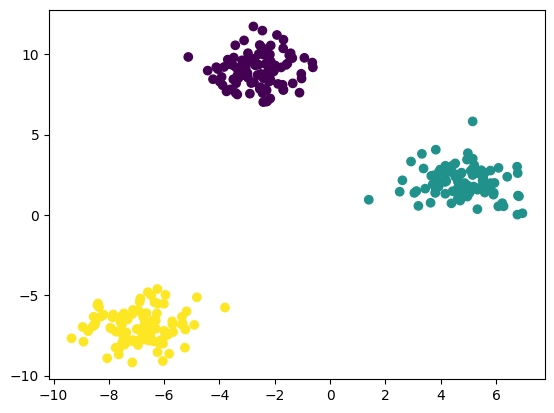

In [94]:
# Create 3 blobs of points (Gaussian clusters) in 2D for K-Means/Hierarchical
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)
plt.scatter(X_blobs[:,0],X_blobs[:,1], c=y_blobs)

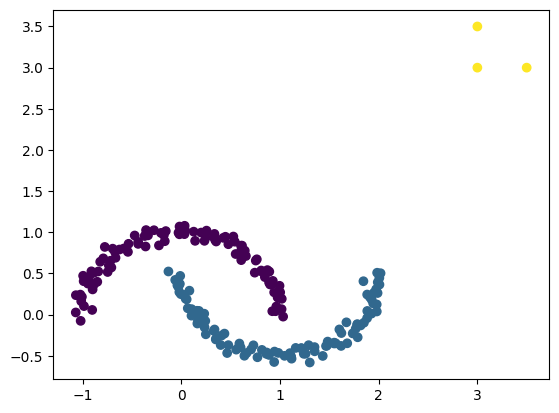

In [95]:
# Create two moons dataset for DBSCAN, with some noise added
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

# Add a few outlier points far away from the moons
X_outliers = np.array([[3, 3], [3.5, 3], [3, 3.5]])
X_moons_out = np.vstack([X_moons, X_outliers])

y_outliers = np.array([3, 3, 3])
y_moons_out = np.hstack([y_moons, y_outliers])

plt.scatter(X_moons_out[:,0], X_moons_out[:,1], c=y_moons_out)

In the code above, `X_blobs` contains 300 points forming three clusters in 2D (useful for K-Means and hierarchical clustering demonstrations). `X_moons_out` contains 200 points in a two-moon shape plus 3 outliers far off from the main clusters (useful for demonstrating DBSCAN’s noise handling).

### K-Means Clustering in Python

We use `sklearn.cluster.KMeans` to perform K-Means clustering on the blob dataset. We will assume we know there are 3 clusters and set `n_clusters=3`. We also set `n_init=10` for more robust centroid initialization (scikit-learn uses K-Means++ by default for centroid initialization).

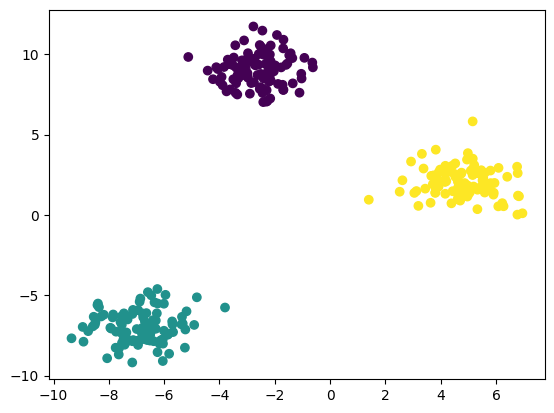

In [96]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
labels_km = kmeans.fit_predict(X_blobs)
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=labels_km)

**Explanation:** 

After fitting, `kmeans.cluster_centers_` contains the coordinates of the 3 centroids found. `labels_km` is an array of cluster indices (0, 1, or 2) assigned to each point in `X_blobs`. The `inertia_` attribute is the final WCSS (sum of squared distances of points to their cluster center). We print the first 10 labels to see an example of assignments.

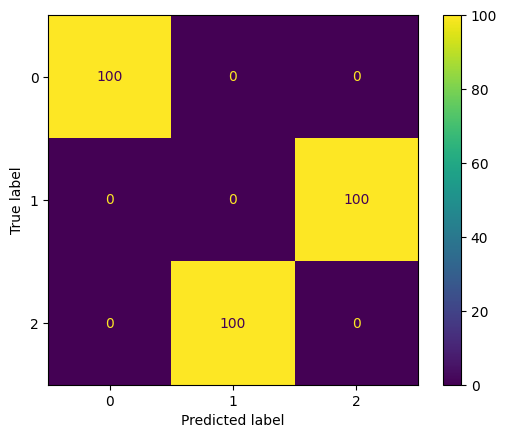

In [97]:
ConfusionMatrixDisplay.from_predictions(y_blobs,labels_km)

### Hierarchical Agglomerative Clustering in Python

Scikit-learn provides `AgglomerativeClustering` for hierarchical clustering. We will cluster the same blob data. Since we know there are 3 natural clusters, we set `n_clusters=3` for a fair comparison (though in practice one might look at the dendrogram to decide this). We can specify a linkage; by default scikit-learn uses Ward’s method (which tends to produce clusters similar to K-Means if clusters are roughly Gaussian), but we could choose `'single'`, `'complete'`, or `'average'` via the `linkage` parameter.

The labels coming from hiearchical clustering might coincide with the K-Means labels in this case (by chance of how labels are numbered) – both identified the natural clusters. 

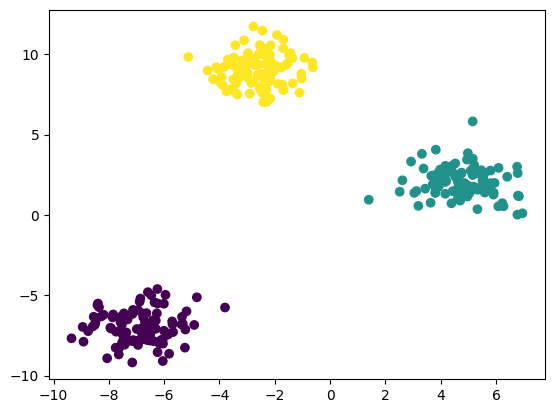

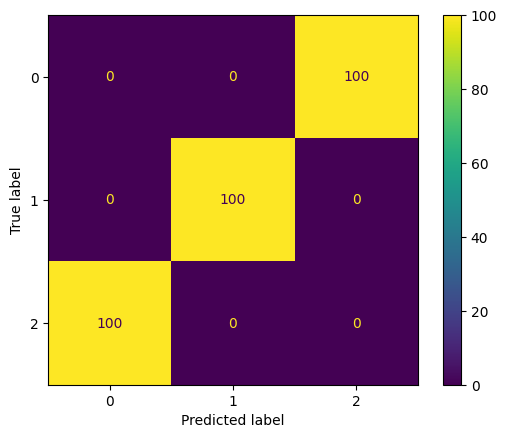

In [98]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hier = agg.fit_predict(X_blobs)
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=labels_hier)
ConfusionMatrixDisplay.from_predictions(y_blobs,labels_hier)

**Explanation:** 

`labels_hier` will contain cluster assignments (0,1,2) for each point, corresponding to the 3 clusters found by the algorithm. The order of labels may not match K-Means, but they represent a partition of the data. We used Ward’s method; if we wanted a full dendrogram, we could use SciPy’s `linkage` function to compute the merge structure.

To illustrate obtaining a dendrogram using SciPy:

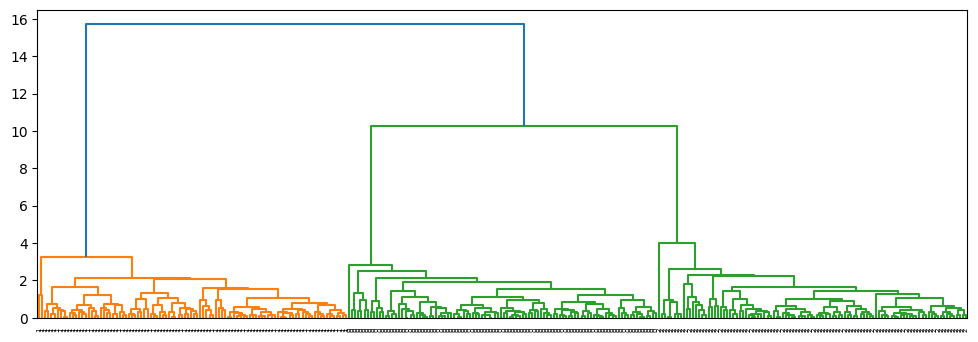

In [124]:
Z = hc.linkage(X_blobs, method='average')
plt.figure(figsize=(12,4))
den = hc.dendrogram(Z, orientation='top',labels=labels_km)

### DBSCAN Clustering in Python

Now we apply **DBSCAN** to the two-moons dataset with outliers (`X_moons_out`). We expect DBSCAN to find 2 clusters (the two moons) and label the few far-out points as noise. We need to choose ε and MinPts. For this dataset, we know the two moons are separated by a gap, so we can choose ε around the scale of that gap. Suppose we pick `eps=0.3` and `min_samples=5` (MinPts=5):

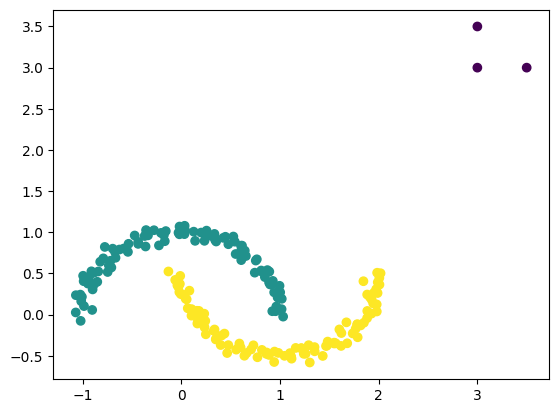

In [100]:
# Perform DBSCAN clustering on the two-moons dataset
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_db = dbscan.fit_predict(X_moons_out)

plt.scatter(X_moons_out[:,0], X_moons_out[:,1], c=labels_db)

**Explanation:** 

After fitting, `labels_db` contains cluster labels for each point in `X_moons_out`. DBSCAN labels noise as -1 by convention. So, `unique_labels` might look like `[-1, 0, 1]` meaning two clusters (0 and 1) and noise (-1). We then count how many points fell into each to see how many noise points versus clustered points.


This output indicates that DBSCAN found 2 clusters (labeled 0 and 1) and labeled 3 points as `-1` (noise). Indeed, we added 3 outlier points, and they have been detected as not belonging to any cluster. Each moon cluster has about 100 points (the original two-moons dataset had 200 points evenly split, minus any that might also be treated as noise if they fell in sparse areas on the fringes). The result demonstrates how DBSCAN can successfully identify the two moon-shaped clusters **without** having to specify the number of clusters, and it naturally excluded the isolated outliers as noise. In contrast, if we ran K-Means with k=2 on the same data, K-Means would force those outliers into one of the 2 clusters, and it might also have difficulty with the non-convex shape of the moons (potentially splitting one moon or mixing parts of both moons) ([A Guide to the DBSCAN Clustering Algorithm | DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=1,usually%20colored%20differently)).

### Additional Notes on Implementation

All three algorithms are available in scikit-learn and are easy to use. Key considerations when implementing:

- **Preprocessing**: Features should be scaled appropriately (especially for distance-based methods like K-Means and DBSCAN). For example, using `StandardScaler` to normalize features can improve clustering results.
- **Initialization (K-Means)**: Using `init='k-means++'` (scikit-learn default) is recommended for K-Means to get better initial centroids. We set `n_init=10` to run the algorithm 10 times and take the best result, which helps avoid unlucky initializations.
- **Linkage Choices (Hierarchical)**: Scikit-learn’s AgglomerativeClustering with `n_clusters` will not produce a full dendrogram. If a full hierarchy is needed, one can use `scipy.cluster.hierarchy` as shown. Scikit-learn does allow retrieving children of merges via the `children_` attribute of the fitted model, but visualization still requires external tools (like SciPy dendrogram or other libraries).
- **Parameter Tuning (DBSCAN)**: It’s often useful to plot the k-distance graph to choose ε. In scikit-learn, one might try multiple eps values or use domain knowledge. MinPts is usually kept fixed to a small value (e.g., 5-10).
- **Performance**: K-Means and DBSCAN can handle fairly large datasets (thousands to millions of points, depending on memory) with efficient implementations. Hierarchical clustering, due to its $O(n^2)$ memory requirement, is typically limited to at most a few tens of thousands of points (and even that can be slow).


# Real Examples
## Iris Dataset

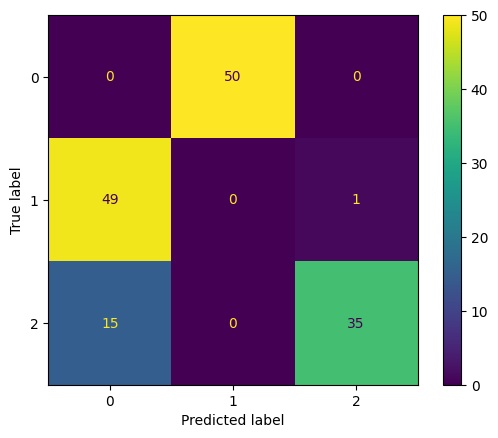

In [125]:
raw = load_iris()
X_iris = raw['data']
y_iris = raw['target']

model = AgglomerativeClustering(n_clusters=3)
model.fit(X_iris)
y_pred = model.fit_predict(X_iris)
ConfusionMatrixDisplay.from_predictions(y_iris,y_pred)

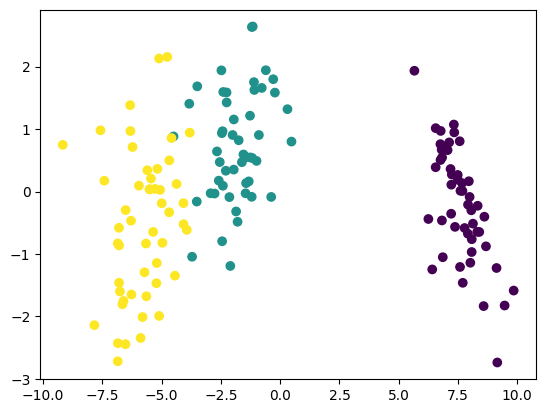

In [126]:
projector = LinearDiscriminantAnalysis(n_components=2)
Xp = projector.fit_transform(X_iris,y_iris)
plt.scatter(Xp[:,0],Xp[:,1],c=y_iris)

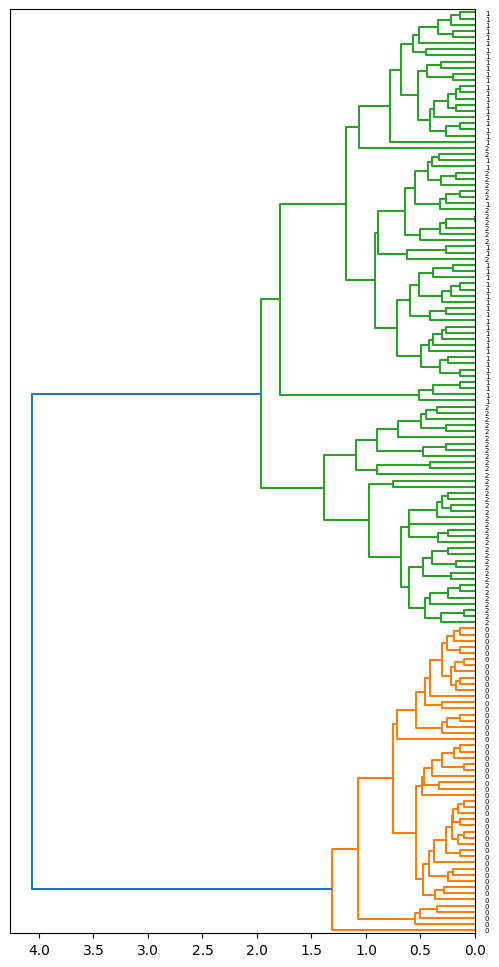

In [127]:
plt.figure(figsize=(6,12))
den = hc.dendrogram(hc.linkage(X_iris, method='average'), orientation='left',labels=y_iris)

### USA Arrests

In [105]:
arrests = rds.data('USArrests')
arrests

,rownames,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


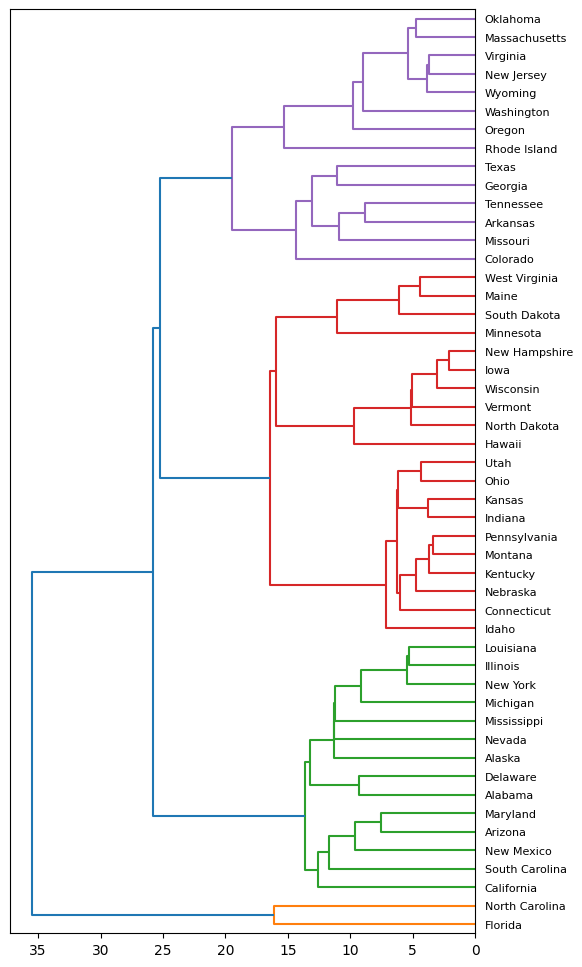

In [108]:
X = arrests[['Murder','Assault','Rape']]
y = arrests['rownames']

plt.figure(figsize=(6,12))
den = hc.dendrogram(hc.linkage(X.to_numpy(), method='single'), orientation='left',labels=y.to_numpy())

### Turkish Crime Statistics



In [109]:
raw = pd.read_excel('../data/turkiye_suc_istatistikleri_2022.xls')
data = raw[raw['Gender'].notna()]
del data['Gender'], data['Total']
data = data.replace('-',0)
data.iloc[:,1:] = data.iloc[:,1:].astype(np.int32)
data

/tmp/ipykernel_126193/2776838312.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('-',0)


,City,Homicide,Assault,Sexual crimes,Kidnapping,Defamation,Theft,Robbery,Swindling,Drugs with intent to sell,...,Forestry crimes,Crimes with deadly weapons,Financial crimes,Military crimes,Threat,Damage to property,Resistance to arrest,Domestic dispute,Other Crimes,Unknown
0,İstanbul,1026,5055,820,811,520,6306,2023,1846,1954,...,43,1655,1230,499,916,292,563,612,6569,61
1,NaN,26,123,6,16,32,487,62,108,131,...,3,9,53,0,25,23,25,25,382,3
3,Tekirdağ,71,453,76,60,46,509,90,58,63,...,2,65,154,239,97,31,46,136,367,2
4,NaN,3,7,0,2,1,23,6,0,10,...,0,0,7,0,2,2,2,1,19,0
6,Edirne,39,260,39,28,28,226,41,38,58,...,2,32,65,200,49,11,20,30,596,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Şırnak,11,59,7,19,5,98,10,16,16,...,0,25,4,45,18,5,15,8,214,1
238,NaN,0,1,0,0,1,3,0,1,0,...,0,0,0,0,1,0,0,0,11,0
240,Siirt,12,95,10,9,6,106,18,3,14,...,1,26,1,16,19,11,13,22,114,0
241,NaN,1,2,0,5,1,3,0,0,0,...,0,0,0,0,0,0,0,0,6,0


In [110]:
N = int((data.shape[0]-1)/2)
tmp = []
for i in range(N):
    tmp.append(data.iloc[2*i,1:]+data.iloc[2*i+1,1:])
    tmp[i] = tmp[i]/sum(tmp[i])
               
X = pd.DataFrame(tmp)
y = [data.iloc[2*i,0] for i in range(N)]

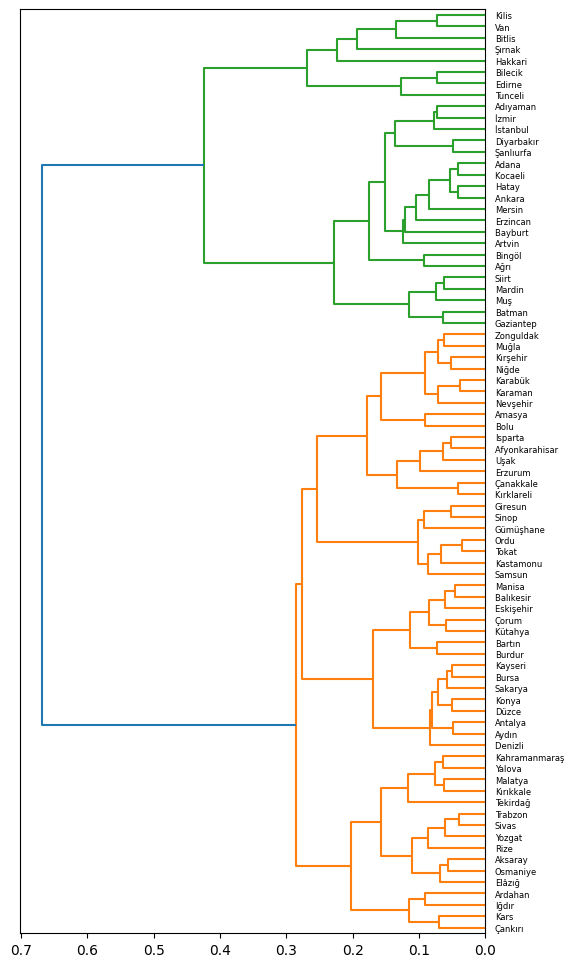

In [111]:
plt.figure(figsize=(6,12))
den = hc.dendrogram(hc.linkage(X, method='ward'), orientation='left',labels=y)

In [112]:
def interactiveDraw(xs,ys,labels,cs,size=(800,400)):
    data = pd.DataFrame({'x': xs, 'y': ys, 'label': labels, 'color': cs})
    return alt.Chart(data).mark_circle(size=100).encode(
                x='x',
                y='y',
                color=alt.Color('color').scale(scheme="dark2"),
                tooltip=['label']
            ).properties(width=size[0],
                         height=size[1]
                        ).interactive()

In [113]:
model = AgglomerativeClustering(n_clusters=3)
colors = model.fit_predict(X)
projector = LinearDiscriminantAnalysis(n_components=2)
turkey_points = projector.fit_transform(X,colors)
interactiveDraw(turkey_points[:,0],turkey_points[:,1],data.dropna().iloc[:81,0],colors,(800,500))

alt.Chart(...)

## The Wine Dataset

For this example, we are going to use the [wine dataset]() 

In [114]:
wine = load_wine()
wine_X = wine['data']
wine_y = wine['target']
pd.DataFrame(wine_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [115]:
projector = LinearDiscriminantAnalysis(n_components=2)
wine_points = projector.fit_transform(wine_X,wine_y)
interactiveDraw(wine_points[:,0],wine_points[:,1],wine_y,wine_y)

alt.Chart(...)

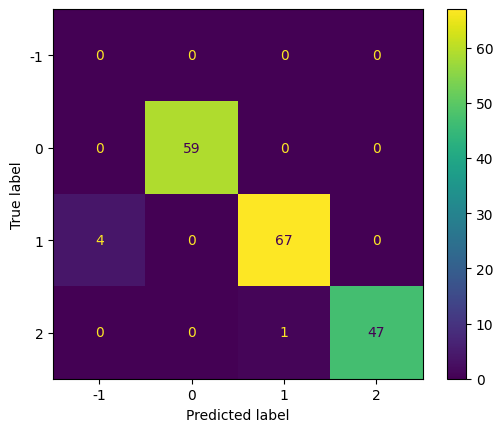

In [116]:
model = DBSCAN(eps=1.0,min_samples=3)
wine_y_pred = model.fit_predict(wine_points)
ConfusionMatrixDisplay.from_predictions(wine_y,wine_y_pred)

## MNIST Digits

In [117]:
raw = load_digits()
digits_X = raw['data']
digits_y = raw['target']
digits_y

array([0, 1, 2, ..., 8, 9, 8], shape=(1797,))

In [118]:
projector = TSNE(n_components=2)
digits_points = projector.fit_transform(digits_X,digits_y)
interactiveDraw(digits_points[:,0],digits_points[:,1],digits_y,digits_y,size=(800,500))

alt.Chart(...)

In [119]:
def displayCM(y_test,y_pred,size=(12,12)):
    disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=None)
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(size[0])
    fig.set_figheight(size[1])  

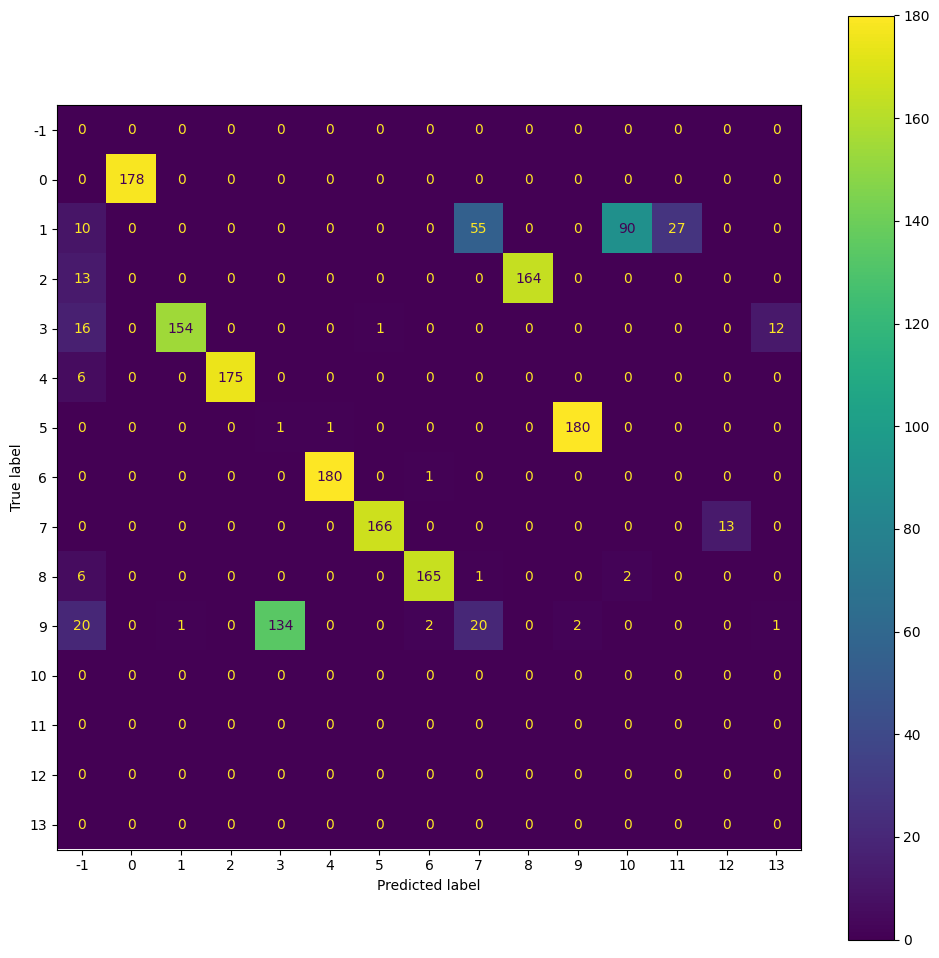

In [120]:
model = DBSCAN(eps=2.9,min_samples=13)
digits_y_pred = model.fit_predict(digits_points)
displayCM(digits_y,digits_y_pred)

## Olivetti Faces

For this example, we are going to use the Olivetti faces dataset.

In [121]:
faces = fetch_olivetti_faces()
faces_X = faces['data']
faces_y = faces['target']

In [122]:
projector = TSNE(n_components=2)
faces_points = projector.fit_transform(faces_X,faces_y)
interactiveDraw(faces_X[:,0],faces_X[:,1],faces_y,faces_y)

alt.Chart(...)

<Figure size 1000x1000 with 0 Axes>

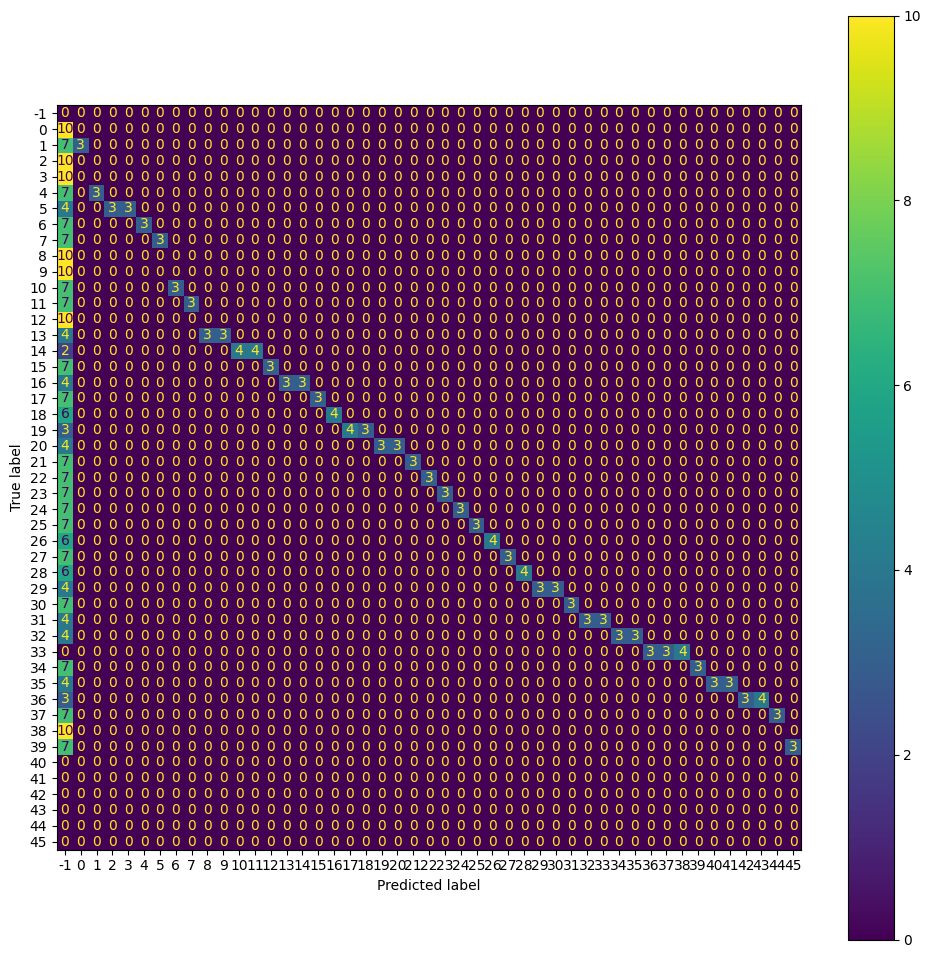

In [123]:
model = DBSCAN(eps=0.9,min_samples=3)
faces_y_pred = model.fit_predict(faces_points)
plt.figure(figsize=(10, 10))
displayCM(faces_y, faces_y_pred)

# Clustering Evaluation Metrics

Clustering evaluation metrics help quantify how well a clustering algorithm has grouped the data. These metrics fall into two categories: **external metrics**, which compare the clustering against an external ground truth or another partition (e.g. Rand Index, Mutual Information), and **internal metrics**, which assess the clustering structure using only the dataset itself (e.g. Silhouette Score). In this document, we delve into three popular metrics – **Rand Index**, **Silhouette Score**, and **Mutual Information** – providing theoretical foundations, mathematical derivations, real-world applications, comparisons of their strengths/weaknesses, and examples of how to compute them in Python. Short, focused sections with equations and examples are used to enhance clarity.

## Rand Index (RI)  

The **Rand Index** (RI) is an external clustering evaluation metric that measures the similarity between two data partitions ([Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20Rand%20index,within%20a%20cluster%20or%20not)). It was introduced by William M. Rand (1971) and essentially computes the percentage of data point *pairs* whose clustering relationship is consistent in the two partitions being compared ([Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=Image%3A%20,choose%202)). In other words, it counts how often two points are either in the same cluster in both partitions or in different clusters in both partitions (these are “agreements”) out of all possible pairs. An RI of 1 indicates that the two clusterings are identical in terms of pairwise relationships, while an RI of 0 indicates maximum disagreement. The Rand Index is *permutation-invariant* to cluster labels (renaming cluster IDs doesn’t change the score) and is symmetric (swapping the two partitions yields the same RI). However, note that RI is **not adjusted for chance** – meaning that even two random, unrelated clusterings can yield a relatively high RI, especially if the number of clusters is very large or very small. This led to the development of the Adjusted Rand Index (ARI), which corrects RI so that the expected value of ARI for random partitions is 0 ([Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20adjusted%20Rand%20index%20is,Index%20was%20corrected%20using%20the)) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=%24)). (We will touch on ARI in the comparisons, though our focus here is on the original Rand Index.)

### Mathematical Derivation  

Consider a dataset of $n$ elements, and suppose we have two partitions of this set: $X = \{X_1, X_2, \dots, X_r\}$ (e.g. the “ground truth” clustering) and $Y = \{Y_1, Y_2, \dots, Y_s\}$ (e.g. the clustering produced by an algorithm) ([Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=%2Co_,s%20subsets%2C%20define%20the%20following)). We define the following counts over all $\binom{n}{2}$ pairs of points ([Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20Rand%20index%2C%20Image%3A%20,2)):

- **$a$:** the number of pairs of points that are **in the same cluster** in $X$ **and** in the same cluster in $Y$ ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=,displaystyle%20Y)). (These are true agreements on “positive” pair grouping.)
- **$b$:** the number of pairs of points that are **in different clusters** in $X$ **and** in different clusters in $Y$ ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=subset%20in%20Image%3A%20,displaystyle%20Y)). (Agreements on “negative” pairing – both clusterings separate these points.)
- **$c$:** the number of pairs that are in the same cluster in $X$ but in different clusters in $Y$ ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=different%20subsets%20in%20Image%3A%20,displaystyle%20Y)). (One clustering joins the pair, the other separates it.)
- **$d$:** the number of pairs that are in different clusters in $X$ but in the same cluster in $Y$ ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=,displaystyle%20Y)). (One clustering separates the pair, the other joins it.)

By definition, $a+b+c+d = \binom{n}{2}$ (the total number of distinct pairs). The **Rand Index** is then formulated as: 

$$
RI \;=\; \frac{a + b}{a + b + c + d} \;=\; \frac{a + b}{\binom{n}{2}} \,,
$$ 

which is the fraction of all pairs on which the two clusterings **agree** ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20Rand%20index%2C%20Image%3A%20,2)). Equivalently, RI can be seen as the accuracy of a binary classification that predicts whether a pair of points is in the same cluster or not, compared to the ground truth partition ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=as%20the%20number%20of%20agreements,displaystyle%20Y)) ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=Image%3A%20,displaystyle%20FP%7D%20is%20the)). In that analogy, $a$ plays the role of true positives (TP), $b$ true negatives (TN), $c$ false negatives (FN), and $d$ false positives (FP); thus $RI = \frac{TP + TN}{TP + TN + FP + FN}$ ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=Image%3A%20,displaystyle%20FP%7D%20is%20the)). 

**Theoretical properties:** RI ranges from 0 to 1. In the best case of identical partitions, $c=d=0$ and $a+b=\binom{n}{2}$, yielding $RI=1$. In the worst case (completely disagreeing clusterings), $a=b=0$ and thus $RI=0$. However, for random clusterings, the expected RI is not 0 – it can be substantially above 0 depending on $r$ and $s$. This is why ARI is often preferred for a fair evaluation, as ARI adjusts the index by subtracting the expected index of random partitions and dividing by the maximum possible index improvement ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20adjusted%20Rand%20index%20is,Index%20was%20corrected%20using%20the)). ARI can sometimes yield small negative values if the agreement is lower than expected by chance, and ARI=1 for perfect agreement. In summary, RI is straightforward and interpretable (as a percentage of pairwise agreements) but must be interpreted with caution when no baseline is considered.


### Strengths, Weaknesses, and Best Use Cases  

**Strengths:** The Rand Index is intuitive and easy to interpret – it directly measures the proportion of decisions (pairwise relationships) on which two clustering assignments agree ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=as%20the%20number%20of%20agreements,displaystyle%20Y)). It treats misclusterings symmetrically (penalizing false merges and false splits of clusters equally) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=This%20section%20introduces%20four%20external,these%20two%20types%20of%20errors)). RI (and ARI) is also not sensitive to relabeling of clusters since it only considers set membership of pairs. It can be computed from a contingency table of cluster assignments without needing the raw data, which is convenient for comparing partitions. 

**Weaknesses:** A key limitation is that RI is **not zero-centered for random partitions** – if clusters are assigned randomly, RI tends to be higher than 0 (sometimes substantially so, especially if the number of clusters is very high or very low) ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20adjusted%20Rand%20index%20is,Index%20was%20corrected%20using%20the)). This makes it hard to judge the absolute goodness of a clustering; an RI of, say, 0.5 could mean “better than chance” or it could be close to random expectation depending on context. This is why one should interpret RI relative to a baseline or use ARI for an absolute sense of agreement. Another issue is that RI gives equal weight to all pairwise agreements; in cases of highly imbalanced cluster sizes, the many pairs of points in large clusters can dominate the score, potentially obscuring the poor clustering of smaller groups. (ARI mitigates some of this by the chance correction and is often recommended when class or cluster sizes are unbalanced ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,and%20there%20exist%20small%20clusters)) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,biased%20towards%20balanced%20clustering%20solutions)).) Additionally, computing RI naively involves considering $O(n^2)$ pairs, which can be computationally expensive for very large $n$, though in practice one uses vectorized computations or formulae based on cluster sizes to compute it efficiently.

**Best Use Cases:** Use Rand Index (or better, ARI) when you have a known ground truth classification or a reference clustering to compare against. It’s well-suited for **external validation** of clustering results in scenarios like: benchmarking clustering algorithms on labeled datasets, validating whether discovered clusters correspond to known categories, or comparing different clustering solutions to each other. If cluster sizes are approximately equal and you want a straightforward similarity measure, ARI/RI works well. If the clustering solution or ground truth has many small clusters or is highly imbalanced, be cautious: ARI is preferable to avoid bias, and even ARI might show biases (e.g. ARI tends to favor solutions that split data into balanced clusters, whereas adjusted mutual information might favor very pure but possibly uneven clusters ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,biased%20towards%20balanced%20clustering%20solutions))). In summary, use Rand Index metrics for **measuring agreement with a reference partition**, and remember to account for chance agreements in your interpretation.

### Real-World Applications  

- **Image Segmentation and Computer Vision:** In image clustering or segmentation tasks, the Rand Index (especially ARI) is used to compare an algorithm’s pixel clusters against ground-truth segmented regions. For example, clustering an image’s pixels into objects vs background can be evaluated by RI against manual annotations – a high RI means the clustering largely agrees with the human-labeled segments. In one example comparing two clustering algorithms on a dataset, an **Adjusted Rand Index of ~0.94** indicates the clusterings are very similar ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=ImageExample%20clusterings%20for%20a%20dataset,displaystyle%20ARI%5Capprox%200.94)) (almost all point pairs were consistently grouped), as illustrated below.  
 ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=ImageExample%20clusterings%20for%20a%20dataset,displaystyle%20ARI%5Capprox%200.94)) ([image]()) *Two different clustering results (left: k-means, right: mean-shift) on the same dataset produce an ARI ≈ 0.94, indicating very high agreement between the two partitions. Points with the same color belong to the same cluster; the high ARI means the color groupings on the left and right plots largely match ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=ImageExample%20clusterings%20for%20a%20dataset,displaystyle%20ARI%5Capprox%200.94)).*  

- **Bioinformatics (Gene/Cell Clustering):** In bioinformatics, clustering algorithms are used to group genes or cells with similar expression profiles. Rand Index and ARI are widely reported to evaluate how well the algorithm’s clusters match known categories such as cell types or experimental conditions ([Clustering spatial transcriptomics data - Oxford Academic](https://academic.oup.com/bioinformatics/article/38/4/997/6384569#:~:text=Clustering%20spatial%20transcriptomics%20data%20,fit%20to%20the%20underlying%20biology)). For example, in single-cell RNA sequencing data, a higher ARI signifies that the clustering of cells is more consistent with known biological cell types or with replicates, indicating a meaningful grouping ([Clustering spatial transcriptomics data - Oxford Academic](https://academic.oup.com/bioinformatics/article/38/4/997/6384569#:~:text=Clustering%20spatial%20transcriptomics%20data%20,fit%20to%20the%20underlying%20biology)).

- **Customer Segmentation:** If a retailer has predefined customer segments (e.g. by demographics or behavior) and we apply a clustering algorithm to discover segments, RI can compare the discovered clusters with the predefined segments. A high RI means the clustering algorithm found groupings that align well with the known segments (this is effectively a validation against a “gold standard” segmentation). Even without an official ground truth, RI can compare two different clustering solutions – for instance, if you apply two algorithms or two sets of features to cluster customers, RI can quantify how similarly they partition the customer base.

- **Document or Topic Clustering:** In natural language processing, one might cluster documents and then evaluate clustering quality by comparing to known topic labels or categories. RI has been used to measure how closely the clusters correspond to true topics. Similarly, in community detection in networks (where “ground truth” communities might be known), RI compares detected communities to the known ones.

*(In practice, the Adjusted Rand Index is often reported in these scenarios, as it provides a more reliable comparison by accounting for chance groupings. When we mention RI in applications, ARI is typically implied unless stated otherwise.)*

## Silhouette Score  

The **Silhouette Score** (or **Silhouette Coefficient**) is an internal evaluation metric that measures how well each data point lies within its cluster *relative to other clusters*. Introduced by Peter J. Rousseeuw in 1987 ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=Silhouette%20is%20a%20method%20of,statistician%20%2050%20in%201987)), the silhouette concept combines two aspects for each point: **cohesion** (how close the point is to others in its own cluster) and **separation** (how far the point is from points in other clusters). The silhouette value for a single data point $i$ is defined as: 

- $a(i)$ = average distance from point $i$ to all other points in the **same cluster** (this measures cluster *cohesion*; smaller $a(i)$ means $i$ is tightly clustered with its peers) ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=Image%3A%20%7B%5Cdisplaystyle%20a%28i%29%3D%7B%5Cfrac%20%7B1%7D%7B%7CC_%7BI%7D%7C,I%7D%2Ci%5Cneq%20j%7Dd%28i%2Cj)) ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=%7CC_%7BI%7D%7C,value%2C%20the%20better%20the%20assignment)).
- $b(i)$ = the minimum average distance from point $i$ to all points in any **other cluster** (this is computed for each other cluster and the smallest of those averages is taken, measuring the distance to the nearest neighboring cluster) ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=For%20each%20data%20point%20Image%3A,I%7D%7D%2C%20we%20now%20define)). This represents cluster *separation* – smaller $b(i)$ means there is another cluster very close to $i$, whereas larger $b(i)$ means $i$ is far from all other clusters.

Given these, the **silhouette score for point $i$** is: 

$$
s(i) \;=\; \frac{b(i) - a(i)}{\max\{a(i),\,b(i)\}} \,, \qquad -1 \le s(i) \le 1\,,
$$ 

when $|C_{I}|>1$ (i.e. the cluster of $i$ has at least 2 points) ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=We%20now%20define%20a%20silhouette,displaystyle%20i)). If $i$ is the only point in its cluster ($|C_I|=1$), one convention is to define $s(i)=0$ (since $a(i)$ is not defined). 

By this formula, $s(i)$ will be close to +1 if $a(i) \ll b(i)$, meaning the point is much closer to its own cluster mates than to any other cluster – a clear assignment. If $s(i)$ is around 0, it means $a(i) \approx b(i)$, so the point is on the border of two clusters (it’s about as close to points in another cluster as to those in its own). If $s(i)$ is negative (which happens if $a(i) > b(i)$), it indicates the point is closer on average to a different cluster than to its own – suggesting it may be misassigned. The **average silhouette score** for a entire clustering is the mean $s(i)$ over all points $i=1,\dots,n$; this gives a summary of how tight and well-separated the clusters are overall ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20value%20is%20a,data%2C%20it%20becomes%20difficult%20to)). The silhouette coefficient inherently ranges from -1 to +1 ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20value%20is%20a,data%2C%20it%20becomes%20difficult%20to)). A higher silhouette (closer to 1) means better defined clusters, while a low or negative silhouette indicates overlapping or improper clusters.

**Interpretation:** Rousseeuw provided rough guidelines: an average silhouette **above 0.7** indicates a strong clustering structure, **0.5** to **0.7** indicates a reasonable structure, **0.25** to **0.5** may be weak and could indicate too many or too few clusters, and **below 0.25** suggests no substantial structure ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=have%20a%20low%20or%20negative,any%20%2052%20metric%2C%20such)). These thresholds, however, depend on data dimensionality and context (in very high-dimensional data, achieving very high silhouette can be difficult ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=have%20a%20low%20or%20negative,any%20%2052%20metric%2C%20such))). Silhouette values are typically used to compare different numbers of clusters or different clustering algorithms on the same data: for example, one might run *k*-means with varying $k$ and choose the $k$ that yields the highest average silhouette (as a way to estimate a suitable number of clusters).

Notably, the silhouette score uses only the data’s distances and cluster assignments – no ground truth labels are required. It can be computed with any distance metric (Euclidean is common, but one could use Manhattan, cosine, etc.) ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=achieve%20such%20high%20values%20because,or%20the%20%2054)) that is appropriate for the data. 

### Mathematical Derivation  

The derivation of the silhouette formula stems from comparing intra-cluster and inter-cluster dissimilarities for each point. For a given point $i$ in cluster $C_I$: 

- First compute $a(i) = \frac{1}{|C_I|-1} \sum_{j \in C_I,\, j \neq i} d(i,j)$, the average distance from $i$ to all other points in its cluster ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=Image%3A%20%7B%5Cdisplaystyle%20a%28i%29%3D%7B%5Cfrac%20%7B1%7D%7B%7CC_%7BI%7D%7C,I%7D%2Ci%5Cneq%20j%7Dd%28i%2Cj)). This is straightforward: sum the distances from $i$ to each other point in $C_I$ and divide by $(|C_I|-1)$. This measures how tightly $i$ is clustered with its own cluster mates. If $a(i)$ is small, $i$ is well integrated into $C_I$. If $a(i)$ is large (relative to typical distances in the dataset), $i$ is in a more spread-out cluster or is an outlier within $C_I$. 

- Next, for every other cluster $C_J$ (for $J \neq I$), compute the average distance from $i$ to all points in $C_J$: $d_{avg}(i, C_J) = \frac{1}{|C_J|} \sum_{j \in C_J} d(i,j)$ ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=We%20then%20define%20the%20mean,I)). Among these values for all $C_J \neq C_I$, let $b(i) = \min_{J \neq I} d_{avg}(i, C_J)$ ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=Image%3A%20,J%7D%7Dd%28i%2Cj)). So $b(i)$ is the distance from $i$ to its “nearest neighboring cluster,” in terms of average linkage. We identify the cluster that is the best alternative for $i$ (the one that $i$ is closest to), and measure how far $i$ is from that cluster on average. 

Now, we compare $a(i)$ and $b(i)$. The silhouette is essentially a *normalized difference*: $s(i) = (b(i) - a(i)) / \max\{a(i), b(i)\}$ ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=We%20now%20define%20a%20silhouette,displaystyle%20i)). We divide by the larger of the two to scale the result between -1 and 1. Three cases: (1) If $a(i) < b(i)$, then $s(i)$ will be positive (good), approaching 1 if $b(i)$ is much larger than $a(i$). (2) If $a(i) \approx b(i)$, $s(i)$ is around 0 (the boundary case). (3) If $a(i) > b(i)$, $s(i)$ becomes negative (meaning $i$ would actually be closer to the other cluster than its own). The formula thus naturally encodes the intuition of what it means for a point to be appropriately clustered.

One can also derive that $-1 \le s(i) \le +1$: Since $a(i) \le \max\{a(i),b(i)\}$ and $b(i) \le \max\{a(i),b(i)\}$, the difference $b(i)-a(i)$ is at most $\max\{a(i),b(i)\}$ (if $a(i)=0$) and at least $-\max\{a(i),b(i)\}$ (if $b(i)=0$ in an extreme hypothetical case), hence $(b-a)/\max\{a,b\}$ lies in $[-1,1]$. The average silhouette for the whole clustering is $S = \frac{1}{n}\sum_{i=1}^n s(i)$, which is the quantity reported as the silhouette score for a clustering solution.

**Theoretical properties:** The silhouette is an *internal validity* measure – it doesn’t require external information and uses the dataset’s own clustering structure. It is bounded between -1 and 1. It is also **agnostic to the clustering algorithm**: any method yielding a partition can be evaluated by computing distances and applying the formula. The silhouette assumes that a notion of distance (dissimilarity) is defined for the data; commonly Euclidean distance in a feature space is used. If the distance metric satisfies triangle inequality and symmetry (like a proper metric), silhouette is well-behaved. If the clustering algorithm optimizes a similar cohesion/separation objective (like *k*-means minimizing within-cluster variance), silhouette often correlates with the objective (higher silhouette for better *k*-means solutions). However, because silhouette uses *average* distances, it implicitly assumes clusters that are convex or at least roughly globular in shape. If clusters are irregularly shaped or have internal substructure, $a(i)$ and $b(i)$ might not capture the true relationship. For example, density-based clusters (like those found by DBSCAN) or non-convex clusters might show lower silhouette even if they are meaningful clusters not separated by simple distance gaps.

Silhouette analysis is widely used for selecting the number of clusters: one computes $S_k$ for different choices of $k$ and picks the $k$ with the highest average silhouette (provided it’s significantly higher than other $k$ values). This method assumes that a natural clustering will yield a markedly better silhouette.

### Strengths, Weaknesses, and Best Use Cases  

**Strengths:** The silhouette score is **interpretability-friendly** – each data point gets a score indicating how well it fits into its cluster, and the average gives an overall assessment ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20value%20is%20a,data%2C%20it%20becomes%20difficult%20to)). It does not require any ground truth or external information, which makes it widely applicable in unsupervised learning. It provides insight at both the cluster level and point level: one can see which clusters have good silhouette (well separated) and which specific points might be problematic. It’s also bounded in a fixed range [-1,1] which makes it easy to judge (values closer to 1 are clearly better). Another strength is that it naturally combines both cohesion and separation – two key aspects of clustering quality – into one metric. This helps avoid the situation of, say, clusters that are tight but very close to each other (which would yield moderate silhouette, correctly signaling an issue) or clusters that are well-separated but very dispersed internally (also yielding moderate silhouette). As a result, silhouette is a more comprehensive internal metric than simply measuring within-cluster variance or between-cluster distances alone.

**Weaknesses:** The silhouette assumes that clusters behave roughly like spheres in the given distance metric space – it uses average distances as a summary. If clusters have non-convex shapes or if data manifolds are complex, silhouette can be misleading. For instance, consider two long, snaking clusters entwined around each other (non-convex): each cluster might have some points relatively close to the other cluster, making $b(i)$ not much larger than $a(i)$, thus silhouette might be low even though a density-based clustering could perfectly separate them. Another limitation is sensitivity to the definition of distance: one must choose an appropriate distance function for the data; a poor choice (or unscaled features) can lead to deceptive silhouette values. Also, silhouette does not handle clusters of single points well (by definition, $s(i)=0$ if a point is alone in its cluster, which might heavily penalize a clustering that legitimately has singleton outliers). **Cluster size bias:** silhouette tends to be higher for partitionings that produce clusters of relatively even size and density. If one cluster is much larger and more dispersed than others, points in that cluster might have higher $a(i)$ (due to more spread-out cluster), and also possibly a lower $b(i)$ (since a large cluster might overlap others), yielding lower silhouette for that cluster. This doesn’t necessarily mean the clustering is “bad” – it could reflect inherent data distribution – but silhouette will flag it. Moreover, in high-dimensional data, distances tend to concentrate, and $a(i)$ and $b(i)$ may become very similar for all points, leading to generally low silhouette values ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=have%20a%20low%20or%20negative,any%20%2052%20metric%2C%20such)) even if some clustering structure exists (this is a symptom of the curse of dimensionality). From a computational standpoint, calculating silhouette requires computing distances between points across clusters; a naive implementation is $O(n^2)$ for $n$ points (because for each point you may examine distance to all others to get $a(i)$ and $b(i)$). However, this can be optimized by precomputing distance matrices or using sampling for large datasets. Still, silhouette can be computationally heavy for extremely large datasets (millions of points) unless optimizations or approximations are used.

**Best Use Cases:** The silhouette score is best used for **internal evaluation** when you do not have ground truth labels. It shines in **determining the appropriate number of clusters** in *k*-means, *k*-medoids, hierarchical clustering, or other partitioning methods. It’s very useful in exploratory data analysis – you can run clustering and use silhouette to gauge if you’ve found something meaningful or if you might be over/under clustering. For example, in customer segmentation or marketing analytics where true segments are not known, silhouette gives a quantitative way to validate if the clusters make sense (with the understanding of its limitations). It’s also a great diagnostic tool to identify problem points or clusters; for instance, in clustering-based anomaly detection, points with low (or negative) silhouette can be examined as potential anomalies. Silhouette is ideal when clusters are expected to be **compact and well-separated** under some distance metric – e.g., clustering well-separated Gaussian blobs, or clustering cities by geographical distance (where clusters might correspond to regions). It is less suitable if clusters are chained, overlapping, or if the concept of distance in feature space doesn’t align with cluster quality (like clustering categorical data with a distance metric might be tricky). In summary, use silhouette to **validate cluster cohesion/separation** and to compare clustering models, especially in the absence of ground truth. Always complement silhouette analysis with domain knowledge and, if possible, other validation methods (because a high silhouette does not guarantee the clustering is conceptually meaningful, only that it’s geometrically well-separated).

### Real-World Applications  

- **Choosing Number of Clusters (Elbow vs Silhouette):** The silhouette score is frequently used in cluster analysis to determine a suitable number of clusters when ground truth is unavailable. For instance, in **customer segmentation**, a business may cluster customers based on purchasing behavior without prior labels. By computing the silhouette for clusterings with $k=2,3,\dots,10$ clusters, the analyst can choose the $k$ that maximizes the average silhouette, indicating the best separation between customer groups. A high silhouette might reveal clear segments like “budget shoppers,” “loyal customers,” etc., whereas a low silhouette would warn that the chosen segmentation is muddled. Silhouette was designed to **visually assess cluster quality**: one can create a *silhouette plot* showing each point’s $s(i)$, sorted by cluster, to see which clusters have generally high or low cohesion/separation ([What is the silhouette statistic in cluster analysis? - The DO Loop](https://blogs.sas.com/content/iml/2023/05/15/silhouette-statistic-cluster.html#:~:text=The%20silhouette%20plot)) ([What is the silhouette statistic in cluster analysis? - The DO Loop](https://blogs.sas.com/content/iml/2023/05/15/silhouette-statistic-cluster.html#:~:text=Rousseeuw%20,for%20the%20example%20data%20set)). Such analysis could show, for example, that adding a fifth cluster splits a well-separated group into two poorly separated ones (lowering silhouette), indicating that four clusters might be optimal.

- **Outlier Identification:** In applications like **anomaly detection** or **image clustering**, silhouette values can help flag points that do not fit well into any cluster. For example, suppose we cluster animal images into groups (cats, dogs, birds). If a particular image (say of a dolphin) is forced into one of these clusters, it might have a low or negative silhouette value because it’s far from the images in its assigned cluster and perhaps closer to some other cluster’s images. Indeed, silhouette plots can reveal such outliers: e.g. in a zoological dataset clustered into mammals, fish, and insects, the silhouette plot showed that *dolphin* and *porpoise* had much lower silhouette scores within the “mammal” cluster, identifying them as potential outliers or misfits in that cluster ([File:Silhouette-plot-orange.png - Wikipedia](https://en.m.wikipedia.org/wiki/File:Silhouette-plot-orange.png#:~:text=Description%20Silhouette)). This usage is valuable in **bioinformatics**, where clustering gene expression data might group most samples well but identify certain samples with low silhouette, suggesting those samples might form a separate cluster or are an outlier type.

- **Comparing Clustering Methods:** Silhouette provides a way to compare different clustering approaches on the same data when no labels are available. For example, in **image segmentation**, one could evaluate a *k*-means clustering versus a spectral clustering by their average silhouette scores to decide which yields more separated segments. In **market segmentation**, different feature sets or algorithms can be compared: perhaps clustering customers by demographic features vs. by purchase history – silhouette scores will indicate which approach produced more cohesive and separated clusters of customers (assuming we have a meaningful distance measure for the features).

- **High-Dimensional Data Insights:** In high-dimensional spaces (like document embeddings or genetic data), distances can be less informative (curse of dimensionality). Nevertheless, silhouette analysis can sometimes diagnose when clustering is spurious. If you attempt to cluster very high-dimensional data and get an average silhouette barely above 0, it suggests the clustering may not be significantly better than random partitioning. For example, clustering random high-dimensional noise will typically yield silhouette scores near 0 (since $a(i) \approx b(i)$ for all points). Thus, silhouette can act as a litmus test for whether any cluster structure was found at all.

## Mutual Information (for Clustering)  

**Mutual Information (MI)** is an information-theoretic measure of association between two random variables. In clustering, we treat the cluster assignments and the true labels (or some reference partition) as two random variables and ask: *how much information does the clustering tell us about the true labels?* If the clustering perfectly reproduces the ground truth classes, then knowing the cluster of a point tells us exactly which class it belongs to (all uncertainty about the class is removed), which means the mutual information is maximal. If the clustering is random with respect to the classes (no better than chance), knowing the cluster gives no information about the class, and mutual information is zero ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24I%28%20%5COmega%20%3B%20%5Cmathbb,In%20particular%2C%20a)) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=classes%20,equal%2C%20fewer%20clusters%20are%20better)). Mutual information is an **external** evaluation metric (requires a ground truth or reference partition). Unlike Rand Index which considers pair agreements, MI considers the overall distribution of points across clusters and classes. It rewards cluster assignments that are “pure” (each cluster largely containing a single class) and matches class proportions.

Formally, suppose we have $r$ clusters $\Omega = \{\omega_1,\omega_2,\dots,\omega_r\}$ from our algorithm and $s$ ground truth classes $\mathbb{C} = \{c_1, c_2, \dots, c_s\}$. We can consider a contingency table where each entry $n_{ij} = |\omega_i \cap c_j|$ is the number of data points that are in cluster $i$ and class $j$. Let $N = n$ be the total number of points. We can interpret selecting a random data point and observing two “random variables”: $X$ = cluster label of the point, and $Y$ = true class of the point. Mutual information $I(X;Y)$ measures how dependent these two variables are. One definition is: 

$$ I(X;Y) = H(X) + H(Y) - H(X,Y) $$ 

where $H(\cdot)$ denotes entropy. Equivalently (for discrete distributions): 

$$ I(X;Y) = \sum_{i=1}^r \sum_{j=1}^s P(X=\omega_i,\, Y=c_j)\, \log \frac{P(X=\omega_i,\, Y=c_j)}{P(X=\omega_i)\,P(Y=c_j)} $$

In our clustering context, $P(X=\omega_i) = \frac{|\omega_i|}{N}$ (the fraction of points in cluster $i$), $P(Y=c_j) = \frac{|c_j|}{N}$ (the fraction of points in class $j$), and $P(X=\omega_i, Y=c_j) = \frac{n_{ij}}{N}$ (the joint probability a random point falls in cluster $i$ and class $j$). Plugging those in, we get a more tangible formula:

$$ I(X;Y) = \sum_{i=1}^r \sum_{j=1}^s \frac{n_{ij}}{N} \; \log \frac{N \cdot n_{ij}}{|\omega_i| \cdot |c_j|} $$

This summation runs over all cluster–class pairs. It accumulates contribution for each cell of the contingency table, weighted by how many points are in that cell ($n_{ij}/N$), and the log measures how far that cell’s proportion is from what we would expect if clustering and class were independent (if independent, we would have $P(X=\omega_i, Y=c_j) = P(X=\omega_i)P(Y=c_j)$, i.e. $n_{ij}/N = (|\omega_i|/N)(|c_j|/N)$). If cluster labels align well with class labels, most points in a given cluster belong to a single class (and vice versa), so the joint distribution strongly deviates from the independent assumption and $I(X;Y)$ is high ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24,vert%5Comega_k%5Cvert%5Cvert%20c_j%5Cvert%7D%24%20%28185)) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24,N%7D%24%20%28187)). If the clustering is random, the distribution factors and $I(X;Y) \approx 0$ ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24I%28%20%5COmega%20%3B%20%5Cmathbb,In%20particular%2C%20a)).

One important property: Mutual information is **maximized** not only when the clustering perfectly matches the classes, but also if the clustering over-partitions the classes. For example, if each class is further split into sub-clusters, the mutual information can still be as high as if it matched classes exactly ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=0%20if%20the%20clustering%20is,things%20being%20equal%2C%20fewer%20clusters)). In fact, if you put every data point in its own cluster ($r = N$), then $I(X;Y)$ reaches its theoretical maximum, because the cluster variable $X$ essentially *encodes* the identity of each point, which certainly contains the information about its class (this is analogous to **purity** metric’s behavior) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=classes%20,equal%2C%20fewer%20clusters%20are%20better)). This means raw mutual information tends to **favor larger numbers of clusters** – it has no penalty for fragmentation of classes into many clusters. To address this, we usually use a **Normalized Mutual Information (NMI)**, which scales the value to a range [0,1] by dividing by a factor related to the entropy of the cluster and class distributions ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=Normalized%20Mutual%20Information%20,average_method)) ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=Image%3A%20,H%7D%20%28X)). Common normalizations include: 

- **Arithmetic mean normalization (a.k.a. “V-measure”)**:
$$ \mathrm{NMI}_{\text{arith}} = \frac{2\, I(X;Y)}{H(X) + H(Y)} $$
This is equivalent to the **V-Measure** used in some literature ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=Normalized%20Mutual%20Information%20,average_method)) ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=Another%20symmetrical%20measure%20is%20the,given%20by)). It gives 1 when clusters perfectly map to classes (or each class is consistently split into clusters in the same way) ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=2005%20)), and 0 when $I(X;Y)=0$ (independent). It compensates for the tendency of $I(X;Y)$ to grow with $H(X)$ or $H(Y)$.

- **Geometric mean normalization**: 
$$ \mathrm{NMI}_{\text{geom}} = \frac{I(X;Y)}{\sqrt{H(X)\,H(Y)}} $$ 
This version also yields 1 for a perfect clustering and 0 for independence ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=analogous%20to%20variance%20%29,akin%20to%20the%20%20177)). It is symmetric and has the nice interpretation similar to a correlation coefficient analogy in information theory.

Both of these NMI definitions (and a few others) are used; in practice, many toolkits (like scikit-learn) default to the arithmetic mean (which they call `v_measure_score` for balanced completeness and homogeneity). NMI ensures that the score is bounded: **0 ≤ NMI ≤ 1**, where 1 means the clustering carries as much information about the class labels as the class labels themselves do (perfect alignment), and 0 means the clustering provides no information about class labels (essentially random with respect to classes) ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=Normalized%20Mutual%20Information%20,average_method)). One thing NMI does **not** fix is chance agreement – even though random clusterings tend to have MI ≈ 0, with finite sample sizes there can be slight positive MI by chance. There is also an **Adjusted Mutual Information (AMI)** which, like ARI, adjusts NMI for chance to have an expected value of 0 for random partitions ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,and%20is%20normalized%20against%20chance)). Unless explicitly stated, by “Mutual Information” in clustering, one often means a normalized version (NMI) since raw MI is unbounded and tricky to interpret on its own ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=Normalized%20Mutual%20Information%20,average_method)). We will focus on NMI for evaluation purposes.

**Interpretation:** Mutual information (and NMI) can be seen as measuring the **reduction in uncertainty about the class labels given the clustering** ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=X,This)) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24,N%7D%24%20%28187)). If each cluster is a pure subset of a single class, the uncertainty of class given cluster is minimal, yielding high MI. If clusters mix multiple classes, the uncertainty remains high, yielding lower MI. NMI of 1 implies that each cluster corresponds exactly to one class (and each class to one or more clusters without mixing), whereas NMI of 0 means knowing the cluster doesn’t tell you anything about the class (clusters are class-heterogeneous in the same proportions as the dataset). Because of normalization, NMI is generally comparable across different experiments (unlike raw MI which could be higher for datasets with more classes, etc.). NMI is symmetric: the mutual information between clustering and class is the same as between class and clustering, so it doesn’t matter which is “ground truth” – it just quantifies agreement. This makes it useful for comparing two different clusterings as well, not only clustering vs known classes ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=This%20metric%20is%20independent%20of,score%20value%20in%20any%20way)).

### A Simple Example

Let us re-consider the example $D = \{1,2,3,4\}$ with $P = \{\{1,2\},\{3,4\}\}$ and $Q = \{\{1,2\},\{3\},\{4\}\}$.

$H(P) = -\frac{2}{4}\log_2(2/4) - \frac{2}{4}\log_2(2/4) = 1$

$H(Q) = -\frac{2}{4}\log_2(2/4) - \frac{1}{4}\log_2(1/4) - \frac{1}{4}\log_2(1/4) = 3/2$

$ p_1 \cap q_1 = \{1,2\} $

$ p_1 \cap q_2 = \emptyset = p_1\cap q_3 = p_2 \cap q_1 $

$ p_2 \cap q_2 = \{3\}$ 

$ p_2 \cap q_3 = \{4\}$

$ H(P|Q) = \frac{2}{4}\log_2(2) + \frac{1}{4} \log_2(2) + \frac{1}{4}\log_2(2) = 1$

### Mathematical Derivation  
Starting from the definition $I(X;Y) = \sum_{i,j} P(X=\omega_i, Y=c_j)\, \log \frac{P(X=\omega_i, Y=c_j)}{P(X=\omega_i)P(Y=c_j)}$, we plug in frequencies from the clustering context. Using $n_{ij}$, $|\omega_i|$, $|c_j|$ as defined above, we have: 

$$
I(X;Y) = \sum_{i=1}^r \sum_{j=1}^s \frac{n_{ij}}{N} \log \frac{\frac{n_{ij}}{N}}{\frac{|\omega_i|}{N} \cdot \frac{|c_j|}{N}} 
= \sum_{i,j} \frac{n_{ij}}{N} \log \frac{n_{ij}\,N}{|\omega_i|\,|c_j|} \,. 
$$

To derive some intuition, we can break this down: The entropy of the class distribution is $H(Y) = -\sum_j \frac{|c_j|}{N} \log \frac{|c_j|}{N}$, and similarly $H(X) = -\sum_i \frac{|\omega_i|}{N} \log \frac{|\omega_i|}{N}$. The joint entropy $H(X,Y) = -\sum_{i,j} \frac{n_{ij}}{N} \log \frac{n_{ij}}{N}$. Then $I(X;Y) = H(X) + H(Y) - H(X,Y)$, which is exactly how much uncertainty in $Y$ is removed by knowing $X$ (or vice versa). If the clustering is very good, $H(Y|X)$ (entropy of $Y$ given cluster) will be low, so $H(X,Y) \approx H(X) + H(Y|X)$ is not much larger than $H(X)$, and thus $I(X;Y) = H(Y) - H(Y|X)$ is close to $H(Y)$. If clustering is bad, $H(Y|X)$ is close to $H(Y)$ (knowing cluster doesn’t reduce much uncertainty in class), so $I(X;Y)$ is close to 0. 

For normalization, the arithmetic NMI formula given earlier can be derived by taking $2I(X;Y)/[H(X)+H(Y)]$. Using the definitions, one can show this is equivalent to the so-called **V-measure**, which itself is the harmonic mean of two metrics called *homogeneity* and *completeness*. A clustering is homogeneous if each cluster contains only members of a single class (no mixed clusters), and complete if all members of a class are in the same cluster (no class is split across clusters). V-measure (and thus NMI with arithmetic mean) rewards both and is symmetric ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=2005%20)). If one desires a different normalization, one could derive the geometric mean version similarly, or even other variants ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=of%20constraint%2C,26)) ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=Image%3A%20,H%7D%20%28X%2CY)). The key property of any NMI is that it corrects the raw MI’s bias of increasing with larger $r$ or $s$. Indeed, as noted, $I(X;Y)$ can attain its maximum when $r = N$ (each point its own cluster, which is usually not a desired outcome for clustering), but $H(X)$ is also maximal in that case (since $X$ is uniformly distributed over $N$ clusters). The normalization by average entropy penalizes such overclustering: if $r = N$, $H(X)$ is large, so the ratio keeps NMI moderate unless those singleton clusters actually correspond exactly to each class partition (which in normal cases they wouldn’t, unless each point is its own class too). In fact, one can prove that NMI (with the entropy-based normalization) has an upper bound of 1 and typically doesn’t inflate with larger cluster counts the way raw MI does ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=classes%20,equal%2C%20fewer%20clusters%20are%20better)) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=The%20normalization%20by%20the%20denominator,entropy%20tends%20to%20increase%20with)).

There is also **Adjusted Mutual Information (AMI)** which involves a more complex formula: $\text{AMI} = \frac{I(X;Y) - E[I(X;Y)]}{\max(I) - E[I(X;Y)]}$, analogous to ARI, where $E[I(X;Y)]$ is the expected mutual information of random clusterings (which is not 0, especially for finite $N$, and needs to be estimated or approximated) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=vs)). AMI further ensures that a completely random assignment yields a score of 0 on average, eliminating any bias due to chance. In practice, if $N$ is large and cluster structures are not extreme, NMI is often sufficient; but for rigorous evaluation across varying $r,s,N$, AMI is the robust choice.

**Theoretical properties:** NMI is bounded [0,1]. It is **symmetric** ($\mathrm{NMI}(X;Y) = \mathrm{NMI}(Y;X)$) ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=This%20metric%20is%20independent%20of,score%20value%20in%20any%20way)). It is *label permutation-invariant* (since it’s based on the contingency counts, relabeling cluster IDs or class IDs doesn’t change $I(X;Y)$). NMI equals 1 if and only if the clustering is a *perfect deterministic function* of the class labels (and vice versa). This can happen if each class is either exactly one cluster or is split into multiple clusters but in a way that each cluster contains only one class (i.e. clustering is a refinement of the class partition). In other words, a clustering that splits a class into subclusters can still yield NMI = 1 if no cluster mixes multiple classes ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=0%20if%20the%20clustering%20is,things%20being%20equal%2C%20fewer%20clusters)). By contrast, ARI would not be 1 in such a case (ARI < 1 if a class is split into multiple clusters unless those clusters are also split in the other partition). This highlights a difference: NMI emphasizes *cluster purity* with respect to classes, whereas ARI emphasizes *pair counting*. This can lead to different sensitivities: for example, if you have one tiny class and the clustering isolates those points perfectly (pure cluster) but mixes some larger classes together, NMI might still be quite high (because that tiny class’s information was captured and purity for large classes still moderately high), while ARI might be lower because many pairs from the large classes got merged incorrectly. In fact, research has noted that **NMI/AMI is biased toward solutions with many pure clusters (even if classes are imbalanced)**, whereas **ARI is biased toward solutions that balance the clustering split of classes** ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,and%20there%20exist%20small%20clusters)) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,biased%20towards%20balanced%20clustering%20solutions)). We’ll discuss this in comparisons.

### Strengths, Weaknesses, and Best Use Cases  

**Strengths:** Mutual Information-based scores (NMI/AMI) provide a *granular evaluation* of clustering against ground truth. They consider the full contingency table of cluster-to-class assignments, thereby using more information than pair-counting alone. This often makes them sensitive to partial alignment: for example, if a cluster aligns 50% with one class and 50% with another, MI will reflect that partial information, whereas Rand Index might treat all those mixed pairs as “errors” without nuance. NMI is bounded and normalized, so one can compare scores across different scenarios (especially using the same normalization method consistently). It handles different numbers of clusters and classes gracefully and is *insensitive to label permutations*. MI treats clustering vs classes in a probabilistic manner, connecting to information theory; thus it has nice interpretations (in bits of information) and relationships to entropy and uncertainty ([Mutual information - Wikipedia](https://en.wikipedia.org/wiki/Mutual_information#:~:text=X,This)) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24,N%7D%24%20%28187)). Another advantage: NMI doesn’t overly penalize a clustering that splits a single class into multiple clusters as long as those clusters are pure – this can be desirable in scenarios where you’re okay with “over-segmentation” as long as clusters aren’t mixing concepts. (For instance, if a true category can be meaningfully divided into subgroups, NMI will still give credit for those clusters being homogeneous, whereas ARI would penalize not keeping them in one cluster.)

**Weaknesses:** A major drawback of raw mutual information is the bias toward larger numbers of clusters (as discussed, more clusters -> potentially higher MI, up to trivial maximum when every point is its own cluster) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=classes%20,equal%2C%20fewer%20clusters%20are%20better)). Normalization mitigates but does not entirely remove all biases. For example, different normalization methods can yield slightly different judgments if class or cluster distributions are very skewed. If one clustering greatly overestimates the number of clusters (splitting classes too finely), NMI will drop somewhat due to the entropy terms, but it might still be higher than one would expect, because those clusters are pure subsets of classes (homogeneity is high). Conversely, if a clustering merges two distinct classes into one cluster (reducing number of clusters), NMI is usually heavily impacted (completeness suffers) – thus NMI is often harsher on errors where distinct classes are confused, than on errors where one class is split apart. This is a double-edged sword: it aligns with how some users perceive clustering quality (not mixing different classes is crucial; splitting a class into subclusters might be acceptable), but in other cases (like wanting exactly one cluster per class) this can be seen as a bias. As noted by researchers, **AMI (adjusted mutual info) tends to be high when clusters are very pure (even if small clusters), and ARI tends to be high when cluster sizes match class sizes well** ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,and%20there%20exist%20small%20clusters)) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,biased%20towards%20balanced%20clustering%20solutions)). So NMI/AMI can overly reward solutions that carve out small pure clusters for rare classes, which might inflate the score without truly getting the big picture right. Another weakness is interpretability: while MI has a rigorous meaning in bits, telling a business stakeholder that “NMI = 0.5” is less intuitive than saying “50% of pairs were correctly grouped” (Rand) or “cluster separation is average” (silhouette). NMI’s value doesn’t directly translate to an easily understandable quantity except in extremes (0 or 1). Also, computing MI from large contingency tables is usually efficient, but if the number of clusters or classes is very high (thousands), one must be careful in implementation to avoid floating-point issues in computing entropy or probabilities. From a chance perspective, NMI is not adjusted for chance, so comparing NMI scores across datasets of different sizes or class distributions should be done with caution. That said, AMI is available to correct for chance, at the cost of a more complex formula.

**Best Use Cases:** Use NMI (or AMI) when you have **ground truth labels or a reliable reference partition** and you want a robust measure of how much the clustering result corresponds to that truth. It is especially useful in scenarios with **imbalanced classes** or differing cluster counts. For example, if you expect the clustering to possibly produce more clusters than true classes (like subdividing categories), NMI will still give a high score if those subdivisions are pure. In **image classification vs clustering** experiments, where some classes may split into multiple visual subclusters, NMI is a preferred metric for evaluation. If you care about not over-segmenting either, then ARI might be used alongside. In **community detection**, if comparing found communities to ground truth communities in a graph, NMI is commonly used because community sizes can vary and NMI handles that well. If your evaluation involves many small clusters or very unbalanced clusters, consider using **AMI**, as it has been recommended for cases with small clusters (it puts more emphasis on identifying even small classes purely) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,and%20there%20exist%20small%20clusters)). On the other hand, if classes are balanced and you care about pair-count accuracy, ARI might suffice. In practice, many works report both ARI and NMI/AMI to cover both perspectives ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=%24)) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=If%20we%20are%20using%20external,the%20biases%20in%20both%20measures)). 

In summary, **Mutual Information metrics** are best when evaluating clustering against a known classification in a nuanced way, giving partial credit for partial matches. They excel in contexts like document clustering, complex image clusters, or multi-class clustering where the number of clusters may not exactly equal the number of classes. They should be used with normalization (NMI) to ensure comparability and boundedness. They are not suitable if no reference labels are present (since they require external truth) – in that case, silhouette or other internal metrics should be used instead.

### Real-World Applications  

- **Clustering vs Classification Benchmarks:** In machine learning research, NMI is a common metric for evaluating clustering algorithms against a known label assignment. For example, in image recognition, one might cluster images based on features and then use NMI to measure how well these clusters align with actual categories (like clustering a mix of handwritten digit images and checking NMI against their true digit labels). High NMI would mean the clustering discovered groupings similar to the actual digit categories. Competitions or papers on clustering often report NMI (or ARI) as a quantitative measure of success when ground truth labels are available.

- **Customer Segmentation Validation:** Consider a **customer segmentation** scenario where customers are clustered from behavior data. If the company has some labeled segments (say “high-spender,” “casual,” “coupon-lover,” etc.), mutual information can be used to see how informative the clusters are about these known segments. A high NMI would indicate the clustering has largely separated these different customer types. Even if the clusters don’t exactly match one-for-one with known segments (maybe it split one segment into two subgroups), NMI will still be high if each cluster tends to align mostly with a single known segment. In fact, practitioners sometimes use NMI as a guide to tune clustering hyperparameters to maximize alignment with a known business segmentation ([12+ Normalized Mutual Information Tips To Boost Accuracy - Web Monitor](https://webmonitor.ucm.colostate.edu/12-normalized-mutual-information-tips-to-boost-accuracy#:~:text=To%20illustrate%20the%20application%20of,NMI%20as%20the%20evaluation%20metric)).

- **Text Document Clustering:** In natural language processing, one may cluster documents (news articles, for example) without labels, but then evaluate the clustering against topic labels or categories using NMI. For instance, cluster news articles by content and then calculate NMI with respect to their news category (politics, sports, tech, etc.). This tells us how much the unsupervised clustering recovered the actual topics. Similarly, in community detection for graphs, if a ground truth community structure is known, NMI can compare the detected communities to the ground truth groupings of nodes.

- **Bioinformatics and Genomics:** In analysis of gene expression or single-cell data, clusters of cells are often compared to known cell types or experimental labels. NMI is used (along with ARI) to evaluate methods that cluster cells – e.g., does the clustering of cells reflect tissue types or experimental conditions? In these domains, class proportions are often uneven (some cell types are rare). AMI (adjusted mutual info) is particularly popular here to account for chance. For example, clustering results in single-cell RNA-seq might be scored by NMI against cell-type labels to quantify how well cell types were recovered ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=0%20if%20the%20clustering%20is,things%20being%20equal%2C%20fewer%20clusters)). Likewise, in gene clustering, if there’s a known categorization of genes (pathways, functions), one can use NMI to see if the clustering correlates with that categorization.

- **Combining Multiple Clusterings (Ensemble):** When combining or comparing multiple clustering results (ensemble clustering or consensus clustering), NMI is often used as a similarity measure between clusterings. Because NMI is symmetric and has a clear interpretation, one can create an “agreement matrix” of multiple clustering runs using NMI scores. For example, if you run a clustering algorithm 10 times with different random initializations, you might compute the NMI between every pair of runs to see the stability of the results (high mutual information between runs means the clustering is stable). Similarly, if you have two different algorithms’ outputs, NMI quantifies their agreement (similar to how one might use ARI for this purpose) ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=This%20metric%20is%20independent%20of,score%20value%20in%20any%20way)).

## Comparing Rand Index, Silhouette, and Mutual Information  

Each of the three metrics we discussed has its own **strengths and weaknesses**, making them suitable for different scenarios. The table below summarizes key differences:

| **Metric**            | **Type**          | **Range**     | **Best Value** | **What it Measures**                 | **Requires Ground Truth?** | **Sensitivity/Biases**                | **Best Use Cases**                           |
|-----------------------|-------------------|---------------|----------------|---------------------------------------|---------------------------|---------------------------------------|----------------------------------------------|
| **Rand Index (RI)**   | External (Pair-based)  | 0 to 1       | 1 = perfect agreement | Fraction of point pairs on which two partitions agree (same or different cluster) ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=Image%3A%20,choose%202)). Essentially pairwise accuracy of clustering vs truth ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=Image%3A%20,displaystyle%20FP%7D%20is%20the)). | Yes (another partition or labels) | – Not 0 for random clusterings (chance bias) unless adjusted (ARI) ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20adjusted%20Rand%20index%20is,Index%20was%20corrected%20using%20the)).<br>– Treats all pair decisions equally; can be dominated by large clusters.<br>– ARI biases: favors balanced clusterings ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,biased%20towards%20balanced%20clustering%20solutions)). | – Comparing clustering result to true labels or to another method’s clustering.<br>– When an intuitive “percentage of correct decisions” measure is desired ([Rand index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index#:~:text=as%20the%20number%20of%20agreements,displaystyle%20Y)).<br>– Use ARI for rigorous comparison especially with different cluster counts or imbalanced classes. |
| **Silhouette Score**  | Internal (Distance-based) | -1 to 1    | +1 = perfectly clustered (cohesion >> separation) | How well each point fits into its cluster vs the nearest other cluster ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=We%20now%20define%20a%20silhouette,displaystyle%20i)). Combines cluster tightness and separation ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20value%20is%20a,data%2C%20it%20becomes%20difficult%20to)). | No (uses only distances)    | – Assumes meaningful distance metric; struggles with non-convex clusters ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=achieve%20such%20high%20values%20because,or%20the%20%2054)).<br>– Tends to decrease in high dimensions due to distance concentration ([Silhouette (clustering) - Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=have%20a%20low%20or%20negative,any%20%2052%20metric%2C%20such)).<br>– Biased against clusters of one point (gives 0) and very uneven cluster sizes. | – Selecting the number of clusters (choose $k$ that maximizes silhouette).<br>– Evaluating clustering quality when no labels are available (unsupervised validation).<br>– Identifying outliers or borderline points (low or negative silhouette). |
| **Mutual Information (NMI)** | External (Information-theoretic) | 0 to 1       | 1 = perfect correlation (up to label permutation) | The amount of information shared between cluster assignments and true labels ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=Image%3A%20%24,vert%5Comega_k%5Cvert%5Cvert%20c_j%5Cvert%7D%24%20%28185)). Rewards clusters that are pure w.r.t classes and vice versa. Often normalized for comparability ([normalized_mutual_info_score — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#:~:text=Normalized%20Mutual%20Information%20,average_method)). | Yes (true labels or reference) | – Without normalization, increases with more clusters (avoid using raw MI) ([Evaluation of clustering](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#:~:text=classes%20,equal%2C%20fewer%20clusters%20are%20better)).<br>– Even with NMI, can favor many small pure clusters (over-segmentation) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=,biased%20towards%20balanced%20clustering%20solutions)).<br>– AMI addresses chance agreements (expected ≈ 0 for random labels). | – Evaluating how well clusters correspond to known classes, especially if some classes might split into sub-clusters.<br>– When partial credit for nearly correct clustering is desired (captures nuance of cluster purity/completeness).<br>– Comparing different clustering results or algorithms on labeled data (report alongside ARI for comprehensive view). |

**Complementarity:** These metrics often complement each other. For example, silhouette is used to decide the number of clusters, then ARI/NMI are used to evaluate the chosen clustering against ground truth. In practice:

- If you **lack ground truth labels**, you must use an internal metric like silhouette (or others like Davies–Bouldin, Dunn index, etc.). Silhouette will tell you how well-defined your clusters are in the feature space. RI and NMI cannot be used in this scenario.
- If you **have ground truth labels** and want to measure clustering performance, RI (especially ARI) and NMI (or AMI) are appropriate. They give slightly different perspectives: ARI focuses on pair counting (which tends to emphasize overall accuracy, treating all errors equally), while NMI focuses on cluster composition (emphasizing pure clustering of classes). It’s not uncommon to report both, since a clustering that maximizes ARI may not maximize NMI and vice versa ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=Image%3A%20enter%20image%20description%20here)) ([clustering - Adjusted Rand Index vs Adjusted Mutual Information - Cross Validated](https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information#:~:text=matching%20the%20reference%20clustering%20with,the%20biases%20in%20both%20measures)). For instance, a clustering that splits one class into two clusters might reduce ARI (because some point pairs of the same class are now separated) but can still achieve NMI=1 if it didn’t mix classes in clusters.
- **Small vs large clusters:** ARI can struggle if there are many small clusters – chance can inflate RI, but ARI corrects that to some extent, yet ARI also tends to down-weight the impact of very small clusters on the score (because there are relatively few pairs involving them). NMI, on the other hand, will give a lot of credit for identifying even a tiny class if it was identified as a distinct cluster (high purity for that class, which contributes to MI). Thus, if your application values identifying even minor groups, NMI/AMI might be a better metric. If your application values the overall accuracy across all pairs equally (e.g., in image segmentation every pixel pair matters equally), ARI might be more suitable.
- **Interpreting absolute values:** An ARI or NMI of 1 is perfect clustering. ARI of 0 indicates random chance level (roughly), NMI of 0 indicates no mutual information. Silhouette close to 1 means clusters are well apart, near 0 means clusters are overlapping, negative means misassignments. It’s worth noting that a “good” silhouette score may vary by domain (in some real datasets, an average silhouette of 0.5 might be very good if data is noisy). Meanwhile, a good ARI/NMI depends on how well-defined the classes are – for example, clustering iris data might yield ARI ~0.75, NMI ~0.75 (as we’ll see in code below), which is considered decent but not perfect since iris has overlapping classes.

In conclusion, there isn’t a single “best” metric – the choice depends on what aspect of clustering quality matters for your problem. **Rand Index/ARI** is excellent for an intuitive sense of agreement and is widely used when comparing to ground truth. **Silhouette** is great for understanding clustering structure without external info and for choosing cluster counts. **Mutual Information/NMI** provides a deeper insight when class labels are known, especially useful if the clustering might refine the classes or if you care about clustering’s information content relative to truth. It’s often recommended to look at multiple metrics to get a complete picture of clustering performance ([cluster analysis - Adjusted Rand Index and Adjusted Mutual ...](https://stackoverflow.com/questions/78694238/adjusted-rand-index-and-adjusted-mutual-information-score-the-same-for-birch-and#:~:text=cluster%20analysis%20,see%20if%20there%20is)).

## Examples  

To demonstrate how these metrics are computed in practice, let’s use Python’s `scikit-learn` library on a simple dataset. We will cluster the famous Iris flower dataset (which has 3 true species classes) using *k*-means into 3 clusters, and then compute the Rand Index, Adjusted Rand Index, Normalized Mutual Information, and Silhouette Score for the result. 

In [141]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
km_labels = kmeans.fit_predict(X_iris)

ri = rand_score(y_iris, km_labels)
ari = adjusted_rand_score(y_iris, km_labels)
nmi = normalized_mutual_info_score(y_iris, km_labels)
sil = silhouette_score(X_iris, km_labels)

print(f"RI: {ri:.3f}")
print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")
print(f"Silhouette: {sil:.3f}")

RI: 0.880
ARI: 0.730
NMI: 0.758
Silhouette: 0.553


These values reflect the quality of the clustering: for iris, *k*-means recovered the species with about 88% pairwise agreement with truth (RI ≈ 0.880), an adjusted Rand of 0.73 (fairly good, considering some species overlap in feature space), NMI ~0.758 indicating a good amount of mutual information between clusters and true species, and an average silhouette ~0.553 suggesting the clusters are reasonably well separated in feature space but not extremely so (which makes sense – iris data has one species that overlaps two clusters). 

In [146]:
rand_score(wine_y,wine_y_pred)

np.float64(0.9757506506697137)

In [147]:
rand_score(faces_y, faces_y_pred)

np.float64(0.5967042606516291)

In [148]:
silhouette_score(wine_points,wine_y),\
silhouette_score(wine_points,wine_y_pred)

(np.float64(0.663169998607709), np.float64(0.5670944631855265))

In [149]:
silhouette_score(faces_points,faces_y),\
silhouette_score(faces_points,faces_y_pred)

(np.float32(0.037230045), np.float32(-0.23730457))

In [150]:
adjusted_mutual_info_score(wine_y,wine_y_pred)

np.float64(0.9355486013340094)

In [151]:
adjusted_mutual_info_score(faces_y,faces_y_pred)

np.float64(0.23292294906476982)

## A final example


In [31]:
interactiveDraw(digits_points[:,0],digits_points[:,1],digits_y,digits_y_pred,size=(800,800))

alt.Chart(...)

In [32]:
def experiment(X_test,y_test,y_pred):
    return {'rand': rand_score(y_test,y_pred),
            'mutual info': adjusted_mutual_info_score(y_test,y_pred),
            'silhouette score labels': silhouette_score(X_test,y_test),
            'silhouette score pred': silhouette_score(X_test,y_pred)}

In [33]:
experiment(digits_points,digits_y,digits_y_pred)

{'rand': np.float64(0.9787111159033925),
 'mutual info': np.float64(0.8966188554637923),
 'silhouette score labels': np.float32(0.5540669),
 'silhouette score pred': np.float32(0.5318952)}

{'rand': 1.0,
 'mutual info': np.float64(1.0),
 'silhouette score labels': np.float64(0.663169998607709),
 'silhouette score pred': np.float64(0.663169998607709)}

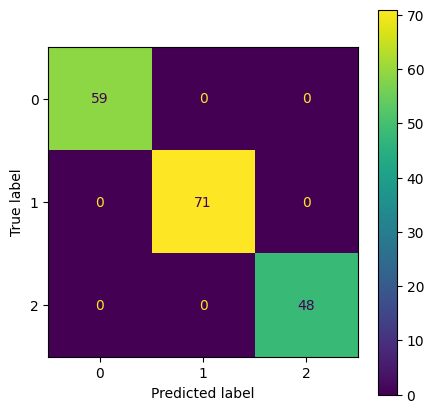

In [34]:
model = KMeans(n_clusters=3)
wine_y_pred = model.fit_predict(wine_points)
displayCM(wine_y,wine_y_pred,size=(5,5))
experiment(wine_points,wine_y,wine_y_pred)

{'rand': 1.0,
 'mutual info': np.float64(1.0),
 'silhouette score labels': np.float64(0.663169998607709),
 'silhouette score pred': np.float64(0.663169998607709)}

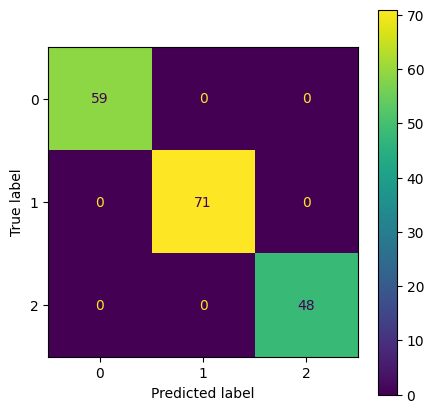

In [35]:
model = AgglomerativeClustering(n_clusters=3)
wine_pred_y = model.fit_predict(wine_X)
displayCM(wine_y,wine_y_pred,size=(5,5))
experiment(wine_points,wine_y,wine_y_pred)

{'rand': np.float64(0.9561353393004507),
 'mutual info': np.float64(0.8856663089486128),
 'silhouette score labels': np.float64(0.663169998607709),
 'silhouette score pred': np.float64(0.5959842887574329)}

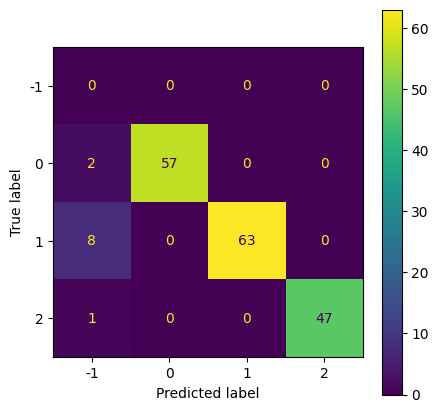

In [36]:
model = DBSCAN(eps=1.0,min_samples=10)
wine_y_pred = model.fit_predict(wine_points)
displayCM(wine_y,wine_y_pred,size=(5,5))
experiment(wine_points,wine_y,wine_y_pred)

In [37]:
model = KMeans(n_clusters=40)
faces_y_pred = model.fit_predict(faces_X)
#displayCM(faces_y,faces_y_pred)
experiment(faces_points,faces_y,faces_y_pred)

{'rand': np.float64(0.9737468671679198),
 'mutual info': np.float64(0.6383089934456853),
 'silhouette score labels': np.float32(0.060838304),
 'silhouette score pred': np.float32(0.10811033)}

In [38]:
model = AgglomerativeClustering(n_clusters=40)
faces_y_pred = model.fit_predict(faces_points)
#displayCM(faces_y,faces_y_pred)
experiment(faces_X,faces_y,faces_y_pred)

{'rand': np.float64(0.9783082706766917),
 'mutual info': np.float64(0.6869365023238204),
 'silhouette score labels': np.float32(0.10557363),
 'silhouette score pred': np.float32(0.11712847)}

{'rand': np.float64(0.5845739348370927),
 'mutual info': np.float64(0.22752478570068374),
 'silhouette score labels': np.float32(0.10557363),
 'silhouette score pred': np.float32(-0.08836367)}

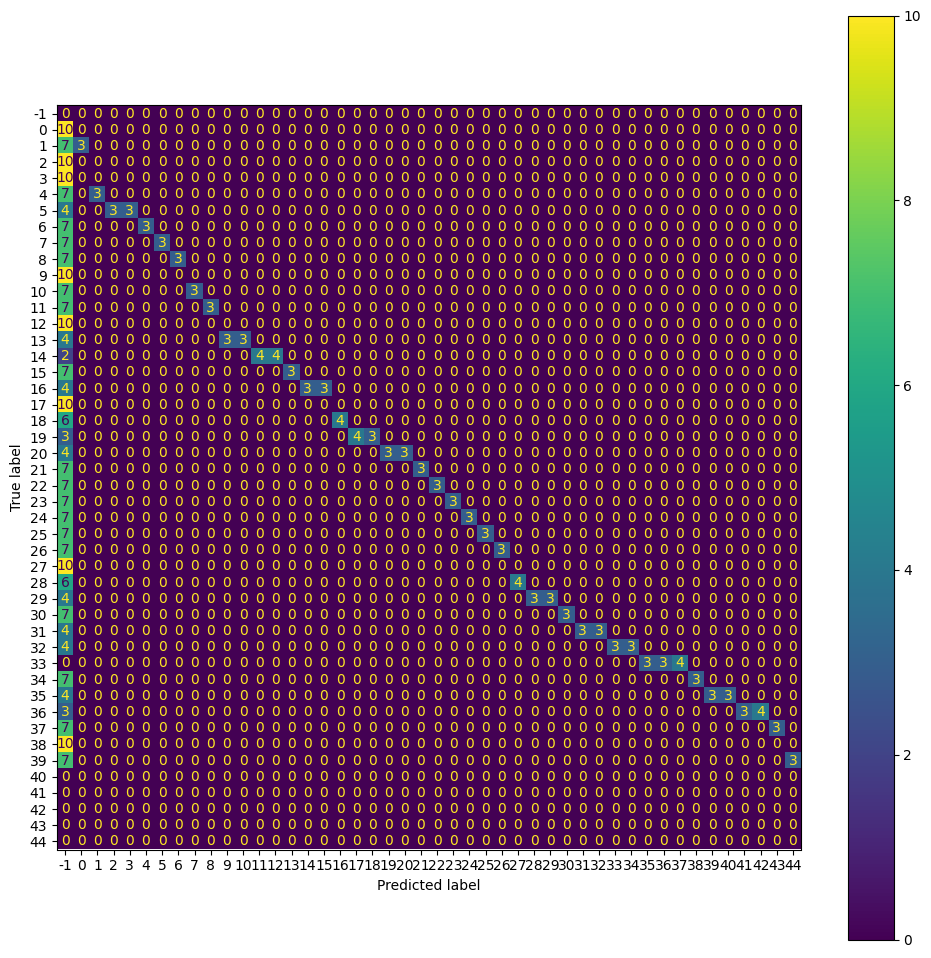

In [39]:
model = DBSCAN(eps=0.9,min_samples=3)
faces_y_pred = model.fit_predict(faces_points)
displayCM(faces_y,faces_y_pred)
experiment(faces_X,faces_y,faces_y_pred)